# SSAP

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [3]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess
import mydatasets as datasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Prepare

In [5]:
# classとclassの色の呼び出し
with open('../data/t_class_name.txt', 'rb') as f:
    t_class_name = pickle.load(f)
with open('../data/t_color.txt', 'rb') as f:
    t_color = pickle.load(f)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
DATA_PATH = "../data/resize/"
IMG_SIZE = 224
# Affinity計算範囲
AFF_R = 5

mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [8]:
print(len(t_color))

81


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R)
# model = model.to(device)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train

In [10]:
# 実験ごとに名前(exp_1)を変更する.
# name = "../exp/exp_1/"
name = '../exp/fullsup_0pretrain/'

!mkdir -p $name
graph = name + "graph/"
!mkdir -p $graph
metrics = name + "metrics/"
!mkdir -p $metrics
trained_model = name + "trained_model/"
!mkdir -p $trained_model

BATCH_SIZE = 10
# BATCH_SIZE = 1

# EPOCH = 100000
EPOCH = 50
SAVE_ITER = 10000
# SAVe_ITER = 10
LOG_ITER = 10
# LOG_ITER = 1

aff_calc_weight = [1.5, 0.5]
aff_weight = 1.
l_aff_weight = [1., 0.3, 0.1, 0.03, 0.01]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
trained_model

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'../exp/fullsup_0pretrain/trained_model/'

In [12]:
# 各値の初期化
random.seed(0)  
np.random.seed(0)  
torch.manual_seed(0)
# img_path = DATA_PATH + "train2014/"
# img_t_path = DATA_PATH + "semantic_train/"
# img_t_ins_path = DATA_PATH + "instance_train/"

img_path = DATA_PATH + "val2017/"
img_t_path = DATA_PATH + "semantic_val/"
img_t_ins_path = DATA_PATH + "instance_val/"

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Datasetの設定
dataset = datasets.Mydatasets(t_color, img_path, img_t_path, img_t_ins_path,
                     IMG_SIZE, AFF_R, mean, std)
tdw_dataset = datasets.TdwAffinityDataset(training=True, mean=mean, std=std, 
                                          raft_ckpt=None, 
                                          single_supervision=False,
                                          full_supervision=True)

trainloader = torch.utils.data.DataLoader(tdw_dataset, batch_size = BATCH_SIZE,
                                          shuffle = True, num_workers = 4)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
len(dataset), len(tdw_dataset)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5000, 35789)

## look at example

In [15]:
data = dataset[0]
for v in data:
    print(v.dtype, v.shape, v.amin(), v.amax())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.float32 torch.Size([3, 224, 224]) tensor(-1.6796) tensor(1.6068)
torch.float64 torch.Size([81, 224, 224]) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.float32 torch.Size([5, 25, 224, 224]) tensor(0.) tensor(1.)


In [16]:
single_ex = 3
data = tdw_dataset[single_ex]
for v in data:
    print(v.dtype, v.shape, v.amin(), v.amax())

torch.float32 torch.Size([3, 256, 256]) tensor(-1.6520) tensor(1.9231)
torch.float32 torch.Size([2, 256, 256]) tensor(0.) tensor(1.)
torch.float32 torch.Size([5, 25, 256, 256]) tensor(0.) tensor(1.)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


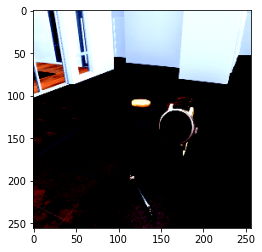

In [17]:
img, semantic, aff_target = data
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


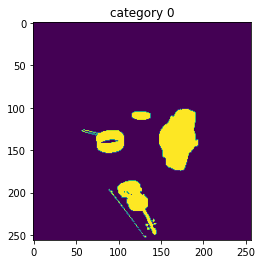

In [18]:
cats = torch.unique(semantic.argmax(0))
# cat_idx = cats[np.random.randint(1, len(cats))]
# plt.imshow(semantic[cat_idx].numpy())
cat_idx = 0
# plt.imshow(semantic.argmax(0).numpy())
plt.imshow(semantic[cat_idx].numpy())
plt.title('category %d' % cat_idx)
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


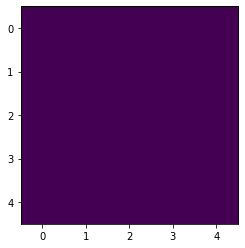

tensor([1.])


In [19]:
level = 4
node = (50,150)
affs = aff_target[level,:,node[0] // (2**level), node[1] // (2**level)].view(AFF_R, AFF_R)
plt.imshow(affs.numpy())
plt.show()
print(torch.unique(affs))

## train model

In [20]:
# Optimizerの指定
use_pretrained = False
model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R, pretrained_backbone=use_pretrained)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


iter:10, loss:0.5551, loss_seg:0.3323, loss_aff:0.2229
iter:20, loss:0.4841, loss_seg:0.2745, loss_aff:0.2096
iter:30, loss:0.4224, loss_seg:0.2240, loss_aff:0.1983
iter:40, loss:0.4164, loss_seg:0.2274, loss_aff:0.1891
iter:50, loss:0.4127, loss_seg:0.2191, loss_aff:0.1936
iter:60, loss:0.3927, loss_seg:0.2147, loss_aff:0.1780
iter:70, loss:0.3461, loss_seg:0.1848, loss_aff:0.1612
iter:80, loss:0.3304, loss_seg:0.1726, loss_aff:0.1578
iter:90, loss:0.4384, loss_seg:0.2691, loss_aff:0.1693
iter:100, loss:0.3598, loss_seg:0.1997, loss_aff:0.1601
iter:110, loss:0.3713, loss_seg:0.2128, loss_aff:0.1584
iter:120, loss:0.3177, loss_seg:0.1704, loss_aff:0.1473
iter:130, loss:0.3006, loss_seg:0.1604, loss_aff:0.1401
iter:140, loss:0.2947, loss_seg:0.1614, loss_aff:0.1333
iter:150, loss:0.3803, loss_seg:0.2135, loss_aff:0.1667
iter:160, loss:0.3621, loss_seg:0.2117, loss_aff:0.1504
iter:170, loss:0.3098, loss_seg:0.1709, loss_aff:0.1389
iter:180, loss:0.3272, loss_seg:0.1830, loss_aff:0.1442
i

iter:1450, loss:0.1532, loss_seg:0.0832, loss_aff:0.0699
iter:1460, loss:0.2077, loss_seg:0.1202, loss_aff:0.0875
iter:1470, loss:0.1238, loss_seg:0.0670, loss_aff:0.0567
iter:1480, loss:0.1720, loss_seg:0.0906, loss_aff:0.0814
iter:1490, loss:0.1415, loss_seg:0.0736, loss_aff:0.0679
iter:1500, loss:0.1636, loss_seg:0.0902, loss_aff:0.0734
iter:1510, loss:0.2298, loss_seg:0.1356, loss_aff:0.0942
iter:1520, loss:0.1650, loss_seg:0.0900, loss_aff:0.0750
iter:1530, loss:0.1899, loss_seg:0.1007, loss_aff:0.0892
iter:1540, loss:0.1941, loss_seg:0.1234, loss_aff:0.0707
iter:1550, loss:0.1237, loss_seg:0.0643, loss_aff:0.0593
iter:1560, loss:0.1173, loss_seg:0.0589, loss_aff:0.0583
iter:1570, loss:0.1794, loss_seg:0.1048, loss_aff:0.0745
iter:1580, loss:0.1336, loss_seg:0.0728, loss_aff:0.0609
iter:1590, loss:0.1485, loss_seg:0.0767, loss_aff:0.0719
iter:1600, loss:0.1629, loss_seg:0.0975, loss_aff:0.0654
iter:1610, loss:0.1687, loss_seg:0.1011, loss_aff:0.0675
iter:1620, loss:0.1165, loss_se

iter:2840, loss:0.0881, loss_seg:0.0427, loss_aff:0.0454
iter:2850, loss:0.1022, loss_seg:0.0570, loss_aff:0.0452
iter:2860, loss:0.1373, loss_seg:0.0770, loss_aff:0.0603
iter:2870, loss:0.1759, loss_seg:0.1088, loss_aff:0.0671
iter:2880, loss:0.0967, loss_seg:0.0479, loss_aff:0.0488
iter:2890, loss:0.0631, loss_seg:0.0321, loss_aff:0.0310
iter:2900, loss:0.1180, loss_seg:0.0616, loss_aff:0.0563
iter:2910, loss:0.1236, loss_seg:0.0627, loss_aff:0.0609
iter:2920, loss:0.1120, loss_seg:0.0567, loss_aff:0.0553
iter:2930, loss:0.1066, loss_seg:0.0553, loss_aff:0.0514
iter:2940, loss:0.0722, loss_seg:0.0374, loss_aff:0.0348
iter:2950, loss:0.0964, loss_seg:0.0528, loss_aff:0.0435
iter:2960, loss:0.0697, loss_seg:0.0362, loss_aff:0.0335
iter:2970, loss:0.0981, loss_seg:0.0529, loss_aff:0.0452
iter:2980, loss:0.1018, loss_seg:0.0543, loss_aff:0.0475
iter:2990, loss:0.1091, loss_seg:0.0568, loss_aff:0.0523
iter:3000, loss:0.0915, loss_seg:0.0527, loss_aff:0.0388
iter:3010, loss:0.1045, loss_se

iter:4260, loss:0.0709, loss_seg:0.0333, loss_aff:0.0376
iter:4270, loss:0.0918, loss_seg:0.0536, loss_aff:0.0382
iter:4280, loss:0.0764, loss_seg:0.0374, loss_aff:0.0390
iter:4290, loss:0.1007, loss_seg:0.0617, loss_aff:0.0391
iter:4300, loss:0.0598, loss_seg:0.0297, loss_aff:0.0301
iter:4310, loss:0.0509, loss_seg:0.0245, loss_aff:0.0264
iter:4320, loss:0.1033, loss_seg:0.0585, loss_aff:0.0448
iter:4330, loss:0.1287, loss_seg:0.0742, loss_aff:0.0545
iter:4340, loss:0.1419, loss_seg:0.0855, loss_aff:0.0564
iter:4350, loss:0.1754, loss_seg:0.1104, loss_aff:0.0650
iter:4360, loss:0.0850, loss_seg:0.0417, loss_aff:0.0434
iter:4370, loss:0.0819, loss_seg:0.0431, loss_aff:0.0388
iter:4380, loss:0.0813, loss_seg:0.0413, loss_aff:0.0400
iter:4390, loss:0.0744, loss_seg:0.0328, loss_aff:0.0416
iter:4400, loss:0.1089, loss_seg:0.0561, loss_aff:0.0528
iter:4410, loss:0.0705, loss_seg:0.0346, loss_aff:0.0359
iter:4420, loss:0.0691, loss_seg:0.0345, loss_aff:0.0346
iter:4430, loss:0.0620, loss_se

iter:5650, loss:0.0595, loss_seg:0.0320, loss_aff:0.0275
iter:5660, loss:0.0839, loss_seg:0.0425, loss_aff:0.0413
iter:5670, loss:0.0427, loss_seg:0.0195, loss_aff:0.0232
iter:5680, loss:0.0467, loss_seg:0.0214, loss_aff:0.0253
iter:5690, loss:0.0679, loss_seg:0.0303, loss_aff:0.0376
iter:5700, loss:0.0762, loss_seg:0.0396, loss_aff:0.0366
iter:5710, loss:0.0700, loss_seg:0.0375, loss_aff:0.0325
iter:5720, loss:0.0616, loss_seg:0.0302, loss_aff:0.0315
iter:5730, loss:0.0557, loss_seg:0.0252, loss_aff:0.0306
iter:5740, loss:0.0839, loss_seg:0.0412, loss_aff:0.0427
iter:5750, loss:0.0565, loss_seg:0.0287, loss_aff:0.0279
iter:5760, loss:0.0885, loss_seg:0.0477, loss_aff:0.0409
iter:5770, loss:0.0868, loss_seg:0.0479, loss_aff:0.0389
iter:5780, loss:0.0741, loss_seg:0.0394, loss_aff:0.0347
iter:5790, loss:0.0743, loss_seg:0.0417, loss_aff:0.0326
iter:5800, loss:0.0752, loss_seg:0.0350, loss_aff:0.0402
iter:5810, loss:0.0680, loss_seg:0.0314, loss_aff:0.0366
iter:5820, loss:0.0791, loss_se

iter:7090, loss:0.0479, loss_seg:0.0275, loss_aff:0.0204
iter:7100, loss:0.0562, loss_seg:0.0276, loss_aff:0.0286
iter:7110, loss:0.0517, loss_seg:0.0245, loss_aff:0.0271
iter:7120, loss:0.0806, loss_seg:0.0452, loss_aff:0.0353
iter:7130, loss:0.0565, loss_seg:0.0270, loss_aff:0.0295
iter:7140, loss:0.0622, loss_seg:0.0360, loss_aff:0.0263
iter:7150, loss:0.0518, loss_seg:0.0292, loss_aff:0.0226
iter:7160, loss:0.0665, loss_seg:0.0306, loss_aff:0.0359
iter:7170, loss:0.0398, loss_seg:0.0209, loss_aff:0.0189
iter:7180, loss:0.0611, loss_seg:0.0319, loss_aff:0.0293
iter:7190, loss:0.0339, loss_seg:0.0156, loss_aff:0.0183
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:7200, loss:0.0852, loss_seg:0.0448, loss_aff:0.0404
iter:7210, loss:0.0592, loss_seg:0.0244, loss_aff:0.0348
iter:7220, loss:0.0811, loss_seg:0.0430, loss_aff:0.0381
iter:7230, loss:0.0575, loss_seg:0.0274, loss_aff:0.0301
iter:72

iter:8480, loss:0.0674, loss_seg:0.0324, loss_aff:0.0349
iter:8490, loss:0.0583, loss_seg:0.0341, loss_aff:0.0242
iter:8500, loss:0.0578, loss_seg:0.0296, loss_aff:0.0281
iter:8510, loss:0.0538, loss_seg:0.0270, loss_aff:0.0268
iter:8520, loss:0.0528, loss_seg:0.0299, loss_aff:0.0229
iter:8530, loss:0.0560, loss_seg:0.0310, loss_aff:0.0251
iter:8540, loss:0.0449, loss_seg:0.0193, loss_aff:0.0256
iter:8550, loss:0.0587, loss_seg:0.0294, loss_aff:0.0294
iter:8560, loss:0.0384, loss_seg:0.0192, loss_aff:0.0192
iter:8570, loss:0.0366, loss_seg:0.0158, loss_aff:0.0208
iter:8580, loss:0.0531, loss_seg:0.0282, loss_aff:0.0249
iter:8590, loss:0.0491, loss_seg:0.0225, loss_aff:0.0267
iter:8600, loss:0.0647, loss_seg:0.0333, loss_aff:0.0314
iter:8610, loss:0.0689, loss_seg:0.0321, loss_aff:0.0368
iter:8620, loss:0.0569, loss_seg:0.0249, loss_aff:0.0320
iter:8630, loss:0.0569, loss_seg:0.0253, loss_aff:0.0316
iter:8640, loss:0.0640, loss_seg:0.0318, loss_aff:0.0322
iter:8650, loss:0.0491, loss_se

iter:9900, loss:0.0759, loss_seg:0.0380, loss_aff:0.0379
iter:9910, loss:0.0877, loss_seg:0.0557, loss_aff:0.0320
iter:9920, loss:0.0490, loss_seg:0.0233, loss_aff:0.0257
iter:9930, loss:0.0512, loss_seg:0.0287, loss_aff:0.0225
iter:9940, loss:0.0448, loss_seg:0.0202, loss_aff:0.0246
iter:9950, loss:0.0378, loss_seg:0.0179, loss_aff:0.0200
iter:9960, loss:0.0331, loss_seg:0.0136, loss_aff:0.0195
iter:9970, loss:0.0652, loss_seg:0.0362, loss_aff:0.0290
iter:9980, loss:0.0406, loss_seg:0.0193, loss_aff:0.0213
iter:9990, loss:0.0441, loss_seg:0.0239, loss_aff:0.0202
iter:10000, loss:0.0759, loss_seg:0.0393, loss_aff:0.0366


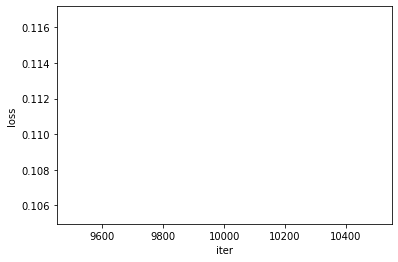

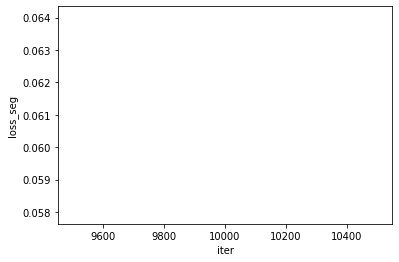

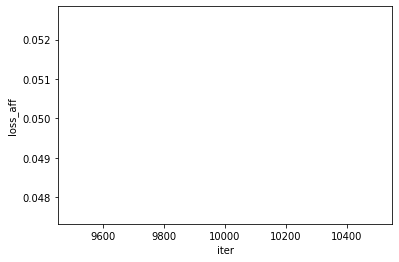

iter:10010, loss:0.0482, loss_seg:0.0219, loss_aff:0.0263
iter:10020, loss:0.0360, loss_seg:0.0176, loss_aff:0.0184
iter:10030, loss:0.0402, loss_seg:0.0174, loss_aff:0.0228
iter:10040, loss:0.0669, loss_seg:0.0293, loss_aff:0.0376
iter:10050, loss:0.0929, loss_seg:0.0492, loss_aff:0.0436
iter:10060, loss:0.0779, loss_seg:0.0412, loss_aff:0.0367
iter:10070, loss:0.0489, loss_seg:0.0253, loss_aff:0.0236
iter:10080, loss:0.0672, loss_seg:0.0349, loss_aff:0.0323
iter:10090, loss:0.0499, loss_seg:0.0234, loss_aff:0.0265
iter:10100, loss:0.0354, loss_seg:0.0161, loss_aff:0.0193
iter:10110, loss:0.0546, loss_seg:0.0252, loss_aff:0.0294
iter:10120, loss:0.0551, loss_seg:0.0251, loss_aff:0.0300
iter:10130, loss:0.0483, loss_seg:0.0264, loss_aff:0.0219
iter:10140, loss:0.0544, loss_seg:0.0272, loss_aff:0.0271
iter:10150, loss:0.0351, loss_seg:0.0177, loss_aff:0.0174
iter:10160, loss:0.0609, loss_seg:0.0297, loss_aff:0.0312
iter:10170, loss:0.0490, loss_seg:0.0222, loss_aff:0.0269
iter:10180, lo

iter:11400, loss:0.0430, loss_seg:0.0217, loss_aff:0.0213
iter:11410, loss:0.0334, loss_seg:0.0143, loss_aff:0.0191
iter:11420, loss:0.0777, loss_seg:0.0490, loss_aff:0.0287
iter:11430, loss:0.0420, loss_seg:0.0216, loss_aff:0.0204
iter:11440, loss:0.0871, loss_seg:0.0468, loss_aff:0.0403
iter:11450, loss:0.0552, loss_seg:0.0246, loss_aff:0.0306
iter:11460, loss:0.0977, loss_seg:0.0606, loss_aff:0.0371
iter:11470, loss:0.0357, loss_seg:0.0193, loss_aff:0.0164
iter:11480, loss:0.0512, loss_seg:0.0272, loss_aff:0.0239
iter:11490, loss:0.0514, loss_seg:0.0261, loss_aff:0.0253
iter:11500, loss:0.0519, loss_seg:0.0218, loss_aff:0.0302
iter:11510, loss:0.0662, loss_seg:0.0354, loss_aff:0.0309
iter:11520, loss:0.0381, loss_seg:0.0192, loss_aff:0.0189
iter:11530, loss:0.0783, loss_seg:0.0354, loss_aff:0.0430
iter:11540, loss:0.0614, loss_seg:0.0330, loss_aff:0.0284
iter:11550, loss:0.0338, loss_seg:0.0151, loss_aff:0.0187
iter:11560, loss:0.0318, loss_seg:0.0156, loss_aff:0.0162
iter:11570, lo

iter:12790, loss:0.0555, loss_seg:0.0250, loss_aff:0.0304
iter:12800, loss:0.0304, loss_seg:0.0142, loss_aff:0.0162
iter:12810, loss:0.0521, loss_seg:0.0247, loss_aff:0.0274
iter:12820, loss:0.0554, loss_seg:0.0256, loss_aff:0.0298
iter:12830, loss:0.0768, loss_seg:0.0421, loss_aff:0.0347
iter:12840, loss:0.0469, loss_seg:0.0230, loss_aff:0.0239
iter:12850, loss:0.0340, loss_seg:0.0156, loss_aff:0.0183
iter:12860, loss:0.0466, loss_seg:0.0204, loss_aff:0.0262
iter:12870, loss:0.0534, loss_seg:0.0274, loss_aff:0.0260
iter:12880, loss:0.0650, loss_seg:0.0327, loss_aff:0.0323
iter:12890, loss:0.0466, loss_seg:0.0233, loss_aff:0.0233
iter:12900, loss:0.0609, loss_seg:0.0335, loss_aff:0.0274
iter:12910, loss:0.1137, loss_seg:0.0670, loss_aff:0.0467
iter:12920, loss:0.0344, loss_seg:0.0162, loss_aff:0.0182
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:12930, loss:0.0504, loss_seg:0.0247, loss_aff

iter:14180, loss:0.0565, loss_seg:0.0301, loss_aff:0.0265
iter:14190, loss:0.0415, loss_seg:0.0182, loss_aff:0.0233
iter:14200, loss:0.0349, loss_seg:0.0167, loss_aff:0.0181
iter:14210, loss:0.0427, loss_seg:0.0220, loss_aff:0.0206
iter:14220, loss:0.0500, loss_seg:0.0217, loss_aff:0.0283
iter:14230, loss:0.0424, loss_seg:0.0191, loss_aff:0.0233
iter:14240, loss:0.0288, loss_seg:0.0128, loss_aff:0.0160
iter:14250, loss:0.0310, loss_seg:0.0126, loss_aff:0.0184
iter:14260, loss:0.1224, loss_seg:0.0869, loss_aff:0.0355
iter:14270, loss:0.0544, loss_seg:0.0295, loss_aff:0.0249
iter:14280, loss:0.0564, loss_seg:0.0283, loss_aff:0.0281
iter:14290, loss:0.0436, loss_seg:0.0207, loss_aff:0.0229
iter:14300, loss:0.0386, loss_seg:0.0166, loss_aff:0.0221
iter:14310, loss:0.0349, loss_seg:0.0173, loss_aff:0.0175
iter:14320, loss:0.0410, loss_seg:0.0186, loss_aff:0.0225
iter:14330, loss:0.0259, loss_seg:0.0126, loss_aff:0.0134
iter:14340, loss:0.0312, loss_seg:0.0161, loss_aff:0.0151
iter:14350, lo

iter:15550, loss:0.0189, loss_seg:0.0076, loss_aff:0.0113
iter:15560, loss:0.0753, loss_seg:0.0390, loss_aff:0.0363
iter:15570, loss:0.0361, loss_seg:0.0145, loss_aff:0.0216
iter:15580, loss:0.0250, loss_seg:0.0117, loss_aff:0.0133
iter:15590, loss:0.0501, loss_seg:0.0252, loss_aff:0.0248
iter:15600, loss:0.0388, loss_seg:0.0174, loss_aff:0.0214
iter:15610, loss:0.0363, loss_seg:0.0157, loss_aff:0.0206
iter:15620, loss:0.0571, loss_seg:0.0320, loss_aff:0.0251
iter:15630, loss:0.0348, loss_seg:0.0169, loss_aff:0.0178
iter:15640, loss:0.0318, loss_seg:0.0152, loss_aff:0.0166
iter:15650, loss:0.0469, loss_seg:0.0226, loss_aff:0.0243
iter:15660, loss:0.0729, loss_seg:0.0369, loss_aff:0.0359
iter:15670, loss:0.0382, loss_seg:0.0177, loss_aff:0.0205
iter:15680, loss:0.0531, loss_seg:0.0200, loss_aff:0.0330
iter:15690, loss:0.0343, loss_seg:0.0145, loss_aff:0.0199
iter:15700, loss:0.0943, loss_seg:0.0445, loss_aff:0.0498
iter:15710, loss:0.0534, loss_seg:0.0249, loss_aff:0.0285
iter:15720, lo

iter:16940, loss:0.0417, loss_seg:0.0210, loss_aff:0.0207
iter:16950, loss:0.0259, loss_seg:0.0117, loss_aff:0.0142
iter:16960, loss:0.0394, loss_seg:0.0184, loss_aff:0.0210
iter:16970, loss:0.0343, loss_seg:0.0149, loss_aff:0.0194
iter:16980, loss:0.0292, loss_seg:0.0147, loss_aff:0.0145
iter:16990, loss:0.0312, loss_seg:0.0140, loss_aff:0.0172
iter:17000, loss:0.0426, loss_seg:0.0236, loss_aff:0.0191
iter:17010, loss:0.0311, loss_seg:0.0138, loss_aff:0.0173
iter:17020, loss:0.0296, loss_seg:0.0131, loss_aff:0.0165
iter:17030, loss:0.0439, loss_seg:0.0192, loss_aff:0.0248
iter:17040, loss:0.0505, loss_seg:0.0216, loss_aff:0.0288
iter:17050, loss:0.0343, loss_seg:0.0132, loss_aff:0.0212
iter:17060, loss:0.0473, loss_seg:0.0242, loss_aff:0.0232
iter:17070, loss:0.0303, loss_seg:0.0152, loss_aff:0.0150
iter:17080, loss:0.0379, loss_seg:0.0161, loss_aff:0.0219
iter:17090, loss:0.0653, loss_seg:0.0366, loss_aff:0.0287
iter:17100, loss:0.0408, loss_seg:0.0191, loss_aff:0.0217
iter:17110, lo

iter:18330, loss:0.0403, loss_seg:0.0181, loss_aff:0.0221
iter:18340, loss:0.0304, loss_seg:0.0137, loss_aff:0.0166
iter:18350, loss:0.0420, loss_seg:0.0175, loss_aff:0.0245
iter:18360, loss:0.0352, loss_seg:0.0151, loss_aff:0.0201
iter:18370, loss:0.0450, loss_seg:0.0215, loss_aff:0.0235
iter:18380, loss:0.0302, loss_seg:0.0147, loss_aff:0.0155
iter:18390, loss:0.0246, loss_seg:0.0117, loss_aff:0.0129
iter:18400, loss:0.0344, loss_seg:0.0163, loss_aff:0.0181
iter:18410, loss:0.0928, loss_seg:0.0751, loss_aff:0.0176
iter:18420, loss:0.0267, loss_seg:0.0146, loss_aff:0.0121
iter:18430, loss:0.0569, loss_seg:0.0318, loss_aff:0.0251
iter:18440, loss:0.0435, loss_seg:0.0203, loss_aff:0.0232
iter:18450, loss:0.0379, loss_seg:0.0186, loss_aff:0.0193
iter:18460, loss:0.0344, loss_seg:0.0161, loss_aff:0.0184
iter:18470, loss:0.0451, loss_seg:0.0221, loss_aff:0.0230
iter:18480, loss:0.0647, loss_seg:0.0401, loss_aff:0.0246
iter:18490, loss:0.0388, loss_seg:0.0179, loss_aff:0.0209
iter:18500, lo

iter:19720, loss:0.0270, loss_seg:0.0120, loss_aff:0.0150
iter:19730, loss:0.0330, loss_seg:0.0136, loss_aff:0.0194
iter:19740, loss:0.0399, loss_seg:0.0152, loss_aff:0.0247
iter:19750, loss:0.0171, loss_seg:0.0074, loss_aff:0.0097
iter:19760, loss:0.0596, loss_seg:0.0279, loss_aff:0.0317
iter:19770, loss:0.0334, loss_seg:0.0147, loss_aff:0.0187
iter:19780, loss:0.0242, loss_seg:0.0115, loss_aff:0.0127
iter:19790, loss:0.0318, loss_seg:0.0154, loss_aff:0.0164
iter:19800, loss:0.0285, loss_seg:0.0123, loss_aff:0.0161
iter:19810, loss:0.0197, loss_seg:0.0087, loss_aff:0.0110
iter:19820, loss:0.0386, loss_seg:0.0161, loss_aff:0.0226
iter:19830, loss:0.0336, loss_seg:0.0153, loss_aff:0.0184
iter:19840, loss:0.0201, loss_seg:0.0094, loss_aff:0.0107
iter:19850, loss:0.0252, loss_seg:0.0108, loss_aff:0.0144
iter:19860, loss:0.0247, loss_seg:0.0107, loss_aff:0.0140
iter:19870, loss:0.0370, loss_seg:0.0171, loss_aff:0.0199
iter:19880, loss:0.0203, loss_seg:0.0099, loss_aff:0.0104
iter:19890, lo

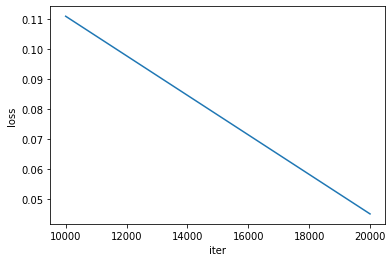

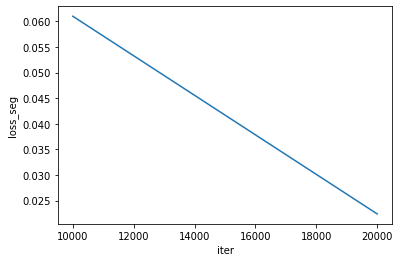

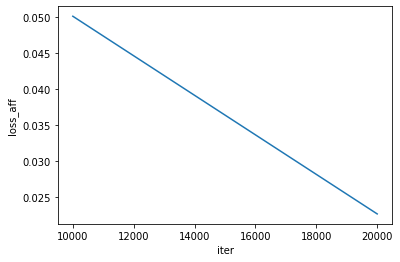

iter:20010, loss:0.1343, loss_seg:0.0915, loss_aff:0.0428
iter:20020, loss:0.0445, loss_seg:0.0207, loss_aff:0.0238
iter:20030, loss:0.1119, loss_seg:0.0749, loss_aff:0.0370
iter:20040, loss:0.0491, loss_seg:0.0245, loss_aff:0.0246
iter:20050, loss:0.0595, loss_seg:0.0277, loss_aff:0.0318
iter:20060, loss:0.0682, loss_seg:0.0390, loss_aff:0.0292
iter:20070, loss:0.0603, loss_seg:0.0277, loss_aff:0.0327
iter:20080, loss:0.0504, loss_seg:0.0263, loss_aff:0.0241
iter:20090, loss:0.0585, loss_seg:0.0299, loss_aff:0.0286
iter:20100, loss:0.0511, loss_seg:0.0246, loss_aff:0.0265
iter:20110, loss:0.0415, loss_seg:0.0176, loss_aff:0.0239
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:20120, loss:0.0361, loss_seg:0.0180, loss_aff:0.0182
iter:20130, loss:0.0305, loss_seg:0.0134, loss_aff:0.0171
iter:20140, loss:0.0616, loss_seg:0.0273, loss_aff:0.0343
iter:20150, loss:0.0374, loss_seg:0.0169, loss_aff

iter:21400, loss:0.0372, loss_seg:0.0165, loss_aff:0.0207
iter:21410, loss:0.0248, loss_seg:0.0095, loss_aff:0.0153
iter:21420, loss:0.0964, loss_seg:0.0568, loss_aff:0.0395
iter:21430, loss:0.0617, loss_seg:0.0338, loss_aff:0.0279
iter:21440, loss:0.0184, loss_seg:0.0079, loss_aff:0.0105
iter:21450, loss:0.0313, loss_seg:0.0166, loss_aff:0.0147
iter:21460, loss:0.0202, loss_seg:0.0081, loss_aff:0.0121
iter:21470, loss:0.0259, loss_seg:0.0111, loss_aff:0.0148
iter:21480, loss:0.0331, loss_seg:0.0136, loss_aff:0.0195
iter:21490, loss:0.0416, loss_seg:0.0168, loss_aff:0.0248
iter:21500, loss:0.0273, loss_seg:0.0118, loss_aff:0.0155
iter:21510, loss:0.0275, loss_seg:0.0129, loss_aff:0.0146
iter:21520, loss:0.0267, loss_seg:0.0123, loss_aff:0.0144
iter:21530, loss:0.0250, loss_seg:0.0111, loss_aff:0.0139
iter:21540, loss:0.0306, loss_seg:0.0132, loss_aff:0.0174
iter:21550, loss:0.0260, loss_seg:0.0112, loss_aff:0.0148
iter:21560, loss:0.0312, loss_seg:0.0144, loss_aff:0.0168
iter:21570, lo

iter:22770, loss:0.0506, loss_seg:0.0243, loss_aff:0.0263
iter:22780, loss:0.0292, loss_seg:0.0129, loss_aff:0.0163
iter:22790, loss:0.0192, loss_seg:0.0080, loss_aff:0.0112
iter:22800, loss:0.0404, loss_seg:0.0175, loss_aff:0.0230
iter:22810, loss:0.0169, loss_seg:0.0086, loss_aff:0.0083
iter:22820, loss:0.0222, loss_seg:0.0101, loss_aff:0.0121
iter:22830, loss:0.0283, loss_seg:0.0130, loss_aff:0.0153
iter:22840, loss:0.0363, loss_seg:0.0186, loss_aff:0.0178
iter:22850, loss:0.0224, loss_seg:0.0094, loss_aff:0.0131
iter:22860, loss:0.0372, loss_seg:0.0155, loss_aff:0.0217
iter:22870, loss:0.0208, loss_seg:0.0093, loss_aff:0.0115
iter:22880, loss:0.0326, loss_seg:0.0142, loss_aff:0.0184
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:22890, loss:0.0320, loss_seg:0.0147, loss_aff:0.0173
iter:22900, loss:0.0323, loss_seg:0.0151, loss_aff:0.0172
iter:22910, loss:0.0298, loss_seg:0.0133, loss_aff

iter:24160, loss:0.0386, loss_seg:0.0232, loss_aff:0.0154
iter:24170, loss:0.0411, loss_seg:0.0188, loss_aff:0.0223
iter:24180, loss:0.0204, loss_seg:0.0091, loss_aff:0.0113
iter:24190, loss:0.0286, loss_seg:0.0133, loss_aff:0.0153
iter:24200, loss:0.0426, loss_seg:0.0223, loss_aff:0.0203
iter:24210, loss:0.0269, loss_seg:0.0106, loss_aff:0.0163
iter:24220, loss:0.0390, loss_seg:0.0142, loss_aff:0.0248
iter:24230, loss:0.0340, loss_seg:0.0160, loss_aff:0.0180
iter:24240, loss:0.0236, loss_seg:0.0100, loss_aff:0.0136
iter:24250, loss:0.0574, loss_seg:0.0257, loss_aff:0.0317
iter:24260, loss:0.0254, loss_seg:0.0111, loss_aff:0.0143
iter:24270, loss:0.0328, loss_seg:0.0142, loss_aff:0.0186
iter:24280, loss:0.0317, loss_seg:0.0169, loss_aff:0.0148
iter:24290, loss:0.0309, loss_seg:0.0137, loss_aff:0.0172
iter:24300, loss:0.0252, loss_seg:0.0115, loss_aff:0.0137
iter:24310, loss:0.0250, loss_seg:0.0114, loss_aff:0.0136
iter:24320, loss:0.0318, loss_seg:0.0149, loss_aff:0.0169
iter:24330, lo

iter:25580, loss:0.0371, loss_seg:0.0197, loss_aff:0.0174
iter:25590, loss:0.0361, loss_seg:0.0162, loss_aff:0.0199
iter:25600, loss:0.0232, loss_seg:0.0112, loss_aff:0.0121
iter:25610, loss:0.0379, loss_seg:0.0177, loss_aff:0.0202
iter:25620, loss:0.0223, loss_seg:0.0095, loss_aff:0.0129
iter:25630, loss:0.0314, loss_seg:0.0142, loss_aff:0.0171
iter:25640, loss:0.0378, loss_seg:0.0153, loss_aff:0.0225
iter:25650, loss:0.0228, loss_seg:0.0092, loss_aff:0.0136
iter:25660, loss:0.0152, loss_seg:0.0066, loss_aff:0.0085
iter:25670, loss:0.0287, loss_seg:0.0129, loss_aff:0.0158
iter:25680, loss:0.0288, loss_seg:0.0138, loss_aff:0.0149
iter:25690, loss:0.0446, loss_seg:0.0227, loss_aff:0.0219
iter:25700, loss:0.0225, loss_seg:0.0100, loss_aff:0.0125
iter:25710, loss:0.0371, loss_seg:0.0143, loss_aff:0.0228
iter:25720, loss:0.0317, loss_seg:0.0199, loss_aff:0.0118
iter:25730, loss:0.0282, loss_seg:0.0135, loss_aff:0.0147
iter:25740, loss:0.0233, loss_seg:0.0110, loss_aff:0.0123
iter:25750, lo

iter:26950, loss:0.0146, loss_seg:0.0072, loss_aff:0.0074
iter:26960, loss:0.0295, loss_seg:0.0128, loss_aff:0.0167
iter:26970, loss:0.0404, loss_seg:0.0202, loss_aff:0.0202
iter:26980, loss:0.0237, loss_seg:0.0097, loss_aff:0.0140
iter:26990, loss:0.0764, loss_seg:0.0595, loss_aff:0.0170
iter:27000, loss:0.0255, loss_seg:0.0129, loss_aff:0.0126
iter:27010, loss:0.0389, loss_seg:0.0179, loss_aff:0.0210
iter:27020, loss:0.0421, loss_seg:0.0241, loss_aff:0.0180
iter:27030, loss:0.0205, loss_seg:0.0093, loss_aff:0.0112
iter:27040, loss:0.0241, loss_seg:0.0114, loss_aff:0.0127
iter:27050, loss:0.0240, loss_seg:0.0105, loss_aff:0.0135
iter:27060, loss:0.0302, loss_seg:0.0148, loss_aff:0.0154
iter:27070, loss:0.0398, loss_seg:0.0183, loss_aff:0.0214
iter:27080, loss:0.0315, loss_seg:0.0169, loss_aff:0.0146
iter:27090, loss:0.0245, loss_seg:0.0091, loss_aff:0.0154
iter:27100, loss:0.0228, loss_seg:0.0097, loss_aff:0.0130
iter:27110, loss:0.0226, loss_seg:0.0104, loss_aff:0.0122
iter:27120, lo

iter:28340, loss:0.0238, loss_seg:0.0119, loss_aff:0.0119
iter:28350, loss:0.0349, loss_seg:0.0152, loss_aff:0.0197
iter:28360, loss:0.0275, loss_seg:0.0113, loss_aff:0.0163
iter:28370, loss:0.0327, loss_seg:0.0149, loss_aff:0.0178
iter:28380, loss:0.0284, loss_seg:0.0160, loss_aff:0.0123
iter:28390, loss:0.0320, loss_seg:0.0136, loss_aff:0.0184
iter:28400, loss:0.0396, loss_seg:0.0217, loss_aff:0.0179
iter:28410, loss:0.0138, loss_seg:0.0061, loss_aff:0.0078
iter:28420, loss:0.0253, loss_seg:0.0140, loss_aff:0.0114
iter:28430, loss:0.0313, loss_seg:0.0139, loss_aff:0.0174
iter:28440, loss:0.0402, loss_seg:0.0177, loss_aff:0.0225
iter:28450, loss:0.0221, loss_seg:0.0093, loss_aff:0.0128
iter:28460, loss:0.0304, loss_seg:0.0120, loss_aff:0.0184
iter:28470, loss:0.0150, loss_seg:0.0065, loss_aff:0.0085
iter:28480, loss:0.0243, loss_seg:0.0113, loss_aff:0.0130
iter:28490, loss:0.0561, loss_seg:0.0217, loss_aff:0.0344
iter:28500, loss:0.0233, loss_seg:0.0093, loss_aff:0.0140
iter:28510, lo

iter:29730, loss:0.0163, loss_seg:0.0077, loss_aff:0.0086
iter:29740, loss:0.0318, loss_seg:0.0137, loss_aff:0.0181
iter:29750, loss:0.0163, loss_seg:0.0076, loss_aff:0.0087
iter:29760, loss:0.0506, loss_seg:0.0312, loss_aff:0.0195
iter:29770, loss:0.0190, loss_seg:0.0088, loss_aff:0.0103
iter:29780, loss:0.0210, loss_seg:0.0095, loss_aff:0.0115
iter:29790, loss:0.0574, loss_seg:0.0305, loss_aff:0.0269
iter:29800, loss:0.0395, loss_seg:0.0217, loss_aff:0.0177
iter:29810, loss:0.0235, loss_seg:0.0089, loss_aff:0.0146
iter:29820, loss:0.0382, loss_seg:0.0216, loss_aff:0.0166
iter:29830, loss:0.0334, loss_seg:0.0147, loss_aff:0.0187
iter:29840, loss:0.0385, loss_seg:0.0190, loss_aff:0.0196
iter:29850, loss:0.0274, loss_seg:0.0081, loss_aff:0.0193
iter:29860, loss:0.0351, loss_seg:0.0167, loss_aff:0.0184
iter:29870, loss:0.0191, loss_seg:0.0085, loss_aff:0.0105
iter:29880, loss:0.0422, loss_seg:0.0203, loss_aff:0.0219
iter:29890, loss:0.0243, loss_seg:0.0099, loss_aff:0.0143
iter:29900, lo

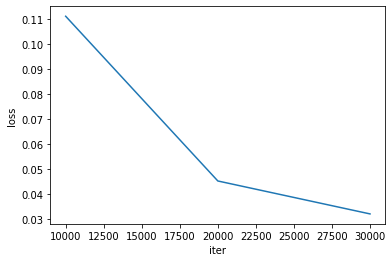

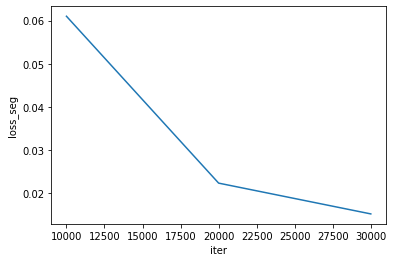

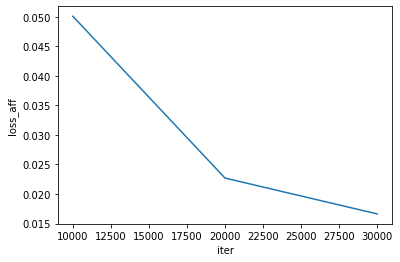

iter:30010, loss:0.0197, loss_seg:0.0088, loss_aff:0.0109
iter:30020, loss:0.0176, loss_seg:0.0075, loss_aff:0.0101
iter:30030, loss:0.0172, loss_seg:0.0062, loss_aff:0.0110
iter:30040, loss:0.0298, loss_seg:0.0123, loss_aff:0.0174
iter:30050, loss:0.0182, loss_seg:0.0085, loss_aff:0.0097
iter:30060, loss:0.0218, loss_seg:0.0105, loss_aff:0.0113
iter:30070, loss:0.0257, loss_seg:0.0098, loss_aff:0.0159
iter:30080, loss:0.0185, loss_seg:0.0090, loss_aff:0.0094
iter:30090, loss:0.0597, loss_seg:0.0317, loss_aff:0.0281
iter:30100, loss:0.0452, loss_seg:0.0222, loss_aff:0.0230
iter:30110, loss:0.0317, loss_seg:0.0149, loss_aff:0.0168
iter:30120, loss:0.0559, loss_seg:0.0318, loss_aff:0.0241
iter:30130, loss:0.0158, loss_seg:0.0076, loss_aff:0.0082
iter:30140, loss:0.0255, loss_seg:0.0138, loss_aff:0.0117
iter:30150, loss:0.0571, loss_seg:0.0267, loss_aff:0.0304
iter:30160, loss:0.0231, loss_seg:0.0113, loss_aff:0.0118
iter:30170, loss:0.0389, loss_seg:0.0173, loss_aff:0.0216
iter:30180, lo

iter:31400, loss:0.0236, loss_seg:0.0098, loss_aff:0.0138
iter:31410, loss:0.0283, loss_seg:0.0122, loss_aff:0.0161
iter:31420, loss:0.0191, loss_seg:0.0066, loss_aff:0.0125
iter:31430, loss:0.0327, loss_seg:0.0143, loss_aff:0.0184
iter:31440, loss:0.0332, loss_seg:0.0160, loss_aff:0.0172
iter:31450, loss:0.0126, loss_seg:0.0064, loss_aff:0.0062
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:31460, loss:0.0222, loss_seg:0.0101, loss_aff:0.0121
iter:31470, loss:0.0314, loss_seg:0.0163, loss_aff:0.0151
iter:31480, loss:0.0725, loss_seg:0.0484, loss_aff:0.0241
iter:31490, loss:0.0365, loss_seg:0.0168, loss_aff:0.0197
iter:31500, loss:0.0321, loss_seg:0.0166, loss_aff:0.0155
iter:31510, loss:0.0404, loss_seg:0.0210, loss_aff:0.0193
iter:31520, loss:0.0330, loss_seg:0.0155, loss_aff:0.0174
iter:31530, loss:0.0269, loss_seg:0.0133, loss_aff:0.0135
iter:31540, loss:0.0202, loss_seg:0.0086, loss_aff:

iter:32790, loss:0.0168, loss_seg:0.0075, loss_aff:0.0093
iter:32800, loss:0.0295, loss_seg:0.0135, loss_aff:0.0160
iter:32810, loss:0.0306, loss_seg:0.0148, loss_aff:0.0158
iter:32820, loss:0.0319, loss_seg:0.0144, loss_aff:0.0175
iter:32830, loss:0.0163, loss_seg:0.0070, loss_aff:0.0093
iter:32840, loss:0.0208, loss_seg:0.0098, loss_aff:0.0110
iter:32850, loss:0.0339, loss_seg:0.0131, loss_aff:0.0207
iter:32860, loss:0.0220, loss_seg:0.0114, loss_aff:0.0106
iter:32870, loss:0.0250, loss_seg:0.0110, loss_aff:0.0140
iter:32880, loss:0.0185, loss_seg:0.0082, loss_aff:0.0102
iter:32890, loss:0.0164, loss_seg:0.0077, loss_aff:0.0087
iter:32900, loss:0.0294, loss_seg:0.0166, loss_aff:0.0129
iter:32910, loss:0.0136, loss_seg:0.0062, loss_aff:0.0074
iter:32920, loss:0.0183, loss_seg:0.0093, loss_aff:0.0090
iter:32930, loss:0.0249, loss_seg:0.0101, loss_aff:0.0148
iter:32940, loss:0.0238, loss_seg:0.0103, loss_aff:0.0135
iter:32950, loss:0.0252, loss_seg:0.0118, loss_aff:0.0134
iter:32960, lo

iter:34210, loss:0.0232, loss_seg:0.0121, loss_aff:0.0111
iter:34220, loss:0.0185, loss_seg:0.0088, loss_aff:0.0098
iter:34230, loss:0.0224, loss_seg:0.0092, loss_aff:0.0132
iter:34240, loss:0.0343, loss_seg:0.0195, loss_aff:0.0148
iter:34250, loss:0.0344, loss_seg:0.0174, loss_aff:0.0170
iter:34260, loss:0.0203, loss_seg:0.0101, loss_aff:0.0103
iter:34270, loss:0.0327, loss_seg:0.0127, loss_aff:0.0200
iter:34280, loss:0.0223, loss_seg:0.0092, loss_aff:0.0131
iter:34290, loss:0.0592, loss_seg:0.0409, loss_aff:0.0183
iter:34300, loss:0.0213, loss_seg:0.0092, loss_aff:0.0122
iter:34310, loss:0.0232, loss_seg:0.0084, loss_aff:0.0147
iter:34320, loss:0.0437, loss_seg:0.0242, loss_aff:0.0195
iter:34330, loss:0.0183, loss_seg:0.0082, loss_aff:0.0101
iter:34340, loss:0.0187, loss_seg:0.0087, loss_aff:0.0099
iter:34350, loss:0.0204, loss_seg:0.0081, loss_aff:0.0123
iter:34360, loss:0.0290, loss_seg:0.0162, loss_aff:0.0129
iter:34370, loss:0.0332, loss_seg:0.0164, loss_aff:0.0168
iter:34380, lo

iter:35580, loss:0.0302, loss_seg:0.0133, loss_aff:0.0169
iter:35590, loss:0.0224, loss_seg:0.0091, loss_aff:0.0133
iter:35600, loss:0.0108, loss_seg:0.0053, loss_aff:0.0055
iter:35610, loss:0.0255, loss_seg:0.0111, loss_aff:0.0143
iter:35620, loss:0.0169, loss_seg:0.0077, loss_aff:0.0092
iter:35630, loss:0.0197, loss_seg:0.0078, loss_aff:0.0120
iter:35640, loss:0.0220, loss_seg:0.0084, loss_aff:0.0136
iter:35650, loss:0.0201, loss_seg:0.0093, loss_aff:0.0108
iter:35660, loss:0.0283, loss_seg:0.0128, loss_aff:0.0155
iter:35670, loss:0.0203, loss_seg:0.0099, loss_aff:0.0104
iter:35680, loss:0.0318, loss_seg:0.0130, loss_aff:0.0188
iter:35690, loss:0.0269, loss_seg:0.0119, loss_aff:0.0150
iter:35700, loss:0.0245, loss_seg:0.0095, loss_aff:0.0150
iter:35710, loss:0.0145, loss_seg:0.0064, loss_aff:0.0081
iter:35720, loss:0.0166, loss_seg:0.0063, loss_aff:0.0103
iter:35730, loss:0.0263, loss_seg:0.0111, loss_aff:0.0153
iter:35740, loss:0.0322, loss_seg:0.0142, loss_aff:0.0180
iter:35750, lo

iter:36970, loss:0.0241, loss_seg:0.0107, loss_aff:0.0134
iter:36980, loss:0.0156, loss_seg:0.0084, loss_aff:0.0072
iter:36990, loss:0.0227, loss_seg:0.0088, loss_aff:0.0139
iter:37000, loss:0.0270, loss_seg:0.0108, loss_aff:0.0161
iter:37010, loss:0.0169, loss_seg:0.0072, loss_aff:0.0097
iter:37020, loss:0.0382, loss_seg:0.0191, loss_aff:0.0191
iter:37030, loss:0.0175, loss_seg:0.0071, loss_aff:0.0104
iter:37040, loss:0.0236, loss_seg:0.0107, loss_aff:0.0129
iter:37050, loss:0.0150, loss_seg:0.0063, loss_aff:0.0087
iter:37060, loss:0.0255, loss_seg:0.0118, loss_aff:0.0137
iter:37070, loss:0.0473, loss_seg:0.0277, loss_aff:0.0196
iter:37080, loss:0.0201, loss_seg:0.0091, loss_aff:0.0111
iter:37090, loss:0.0202, loss_seg:0.0104, loss_aff:0.0099
iter:37100, loss:0.0125, loss_seg:0.0062, loss_aff:0.0063
iter:37110, loss:0.0246, loss_seg:0.0101, loss_aff:0.0146
iter:37120, loss:0.0227, loss_seg:0.0116, loss_aff:0.0112
iter:37130, loss:0.0229, loss_seg:0.0096, loss_aff:0.0134
Encounter erro

iter:38360, loss:0.0227, loss_seg:0.0100, loss_aff:0.0127
iter:38370, loss:0.0236, loss_seg:0.0109, loss_aff:0.0127
iter:38380, loss:0.0179, loss_seg:0.0091, loss_aff:0.0088
iter:38390, loss:0.0170, loss_seg:0.0068, loss_aff:0.0103
iter:38400, loss:0.0192, loss_seg:0.0082, loss_aff:0.0110
iter:38410, loss:0.0147, loss_seg:0.0069, loss_aff:0.0078
iter:38420, loss:0.0282, loss_seg:0.0131, loss_aff:0.0150
iter:38430, loss:0.0152, loss_seg:0.0070, loss_aff:0.0082
iter:38440, loss:0.0213, loss_seg:0.0091, loss_aff:0.0122
iter:38450, loss:0.0146, loss_seg:0.0068, loss_aff:0.0078
iter:38460, loss:0.0262, loss_seg:0.0102, loss_aff:0.0161
iter:38470, loss:0.0223, loss_seg:0.0086, loss_aff:0.0136
iter:38480, loss:0.0096, loss_seg:0.0052, loss_aff:0.0044
iter:38490, loss:0.0216, loss_seg:0.0089, loss_aff:0.0127
iter:38500, loss:0.0240, loss_seg:0.0117, loss_aff:0.0123
iter:38510, loss:0.0089, loss_seg:0.0039, loss_aff:0.0050
iter:38520, loss:0.0145, loss_seg:0.0053, loss_aff:0.0092
iter:38530, lo

iter:39710, loss:0.0252, loss_seg:0.0112, loss_aff:0.0140
iter:39720, loss:0.0161, loss_seg:0.0074, loss_aff:0.0088
iter:39730, loss:0.0225, loss_seg:0.0076, loss_aff:0.0149
iter:39740, loss:0.0179, loss_seg:0.0078, loss_aff:0.0101
iter:39750, loss:0.0173, loss_seg:0.0073, loss_aff:0.0100
iter:39760, loss:0.0165, loss_seg:0.0071, loss_aff:0.0094
iter:39770, loss:0.0194, loss_seg:0.0089, loss_aff:0.0105
iter:39780, loss:0.0189, loss_seg:0.0086, loss_aff:0.0103
iter:39790, loss:0.0139, loss_seg:0.0066, loss_aff:0.0073
iter:39800, loss:0.0197, loss_seg:0.0096, loss_aff:0.0101
iter:39810, loss:0.0375, loss_seg:0.0141, loss_aff:0.0235
iter:39820, loss:0.0100, loss_seg:0.0057, loss_aff:0.0044
iter:39830, loss:0.0260, loss_seg:0.0121, loss_aff:0.0140
iter:39840, loss:0.0260, loss_seg:0.0115, loss_aff:0.0145
iter:39850, loss:0.0365, loss_seg:0.0153, loss_aff:0.0213
iter:39860, loss:0.0162, loss_seg:0.0062, loss_aff:0.0101
iter:39870, loss:0.0118, loss_seg:0.0058, loss_aff:0.0060
iter:39880, lo

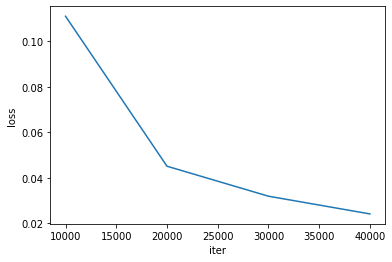

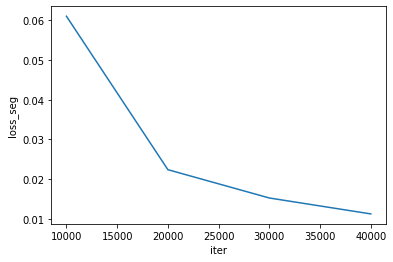

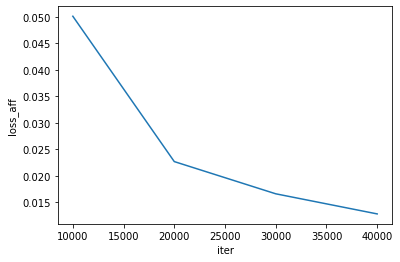

iter:40010, loss:0.0347, loss_seg:0.0160, loss_aff:0.0187
iter:40020, loss:0.0255, loss_seg:0.0105, loss_aff:0.0150
iter:40030, loss:0.0308, loss_seg:0.0147, loss_aff:0.0161
iter:40040, loss:0.0176, loss_seg:0.0077, loss_aff:0.0099
iter:40050, loss:0.0191, loss_seg:0.0087, loss_aff:0.0104
iter:40060, loss:0.0148, loss_seg:0.0055, loss_aff:0.0093
iter:40070, loss:0.0190, loss_seg:0.0082, loss_aff:0.0109
iter:40080, loss:0.0216, loss_seg:0.0094, loss_aff:0.0122
iter:40090, loss:0.0167, loss_seg:0.0073, loss_aff:0.0094
iter:40100, loss:0.0134, loss_seg:0.0050, loss_aff:0.0084
iter:40110, loss:0.0147, loss_seg:0.0070, loss_aff:0.0077
iter:40120, loss:0.0089, loss_seg:0.0042, loss_aff:0.0047
iter:40130, loss:0.0207, loss_seg:0.0087, loss_aff:0.0120
iter:40140, loss:0.0094, loss_seg:0.0047, loss_aff:0.0047
iter:40150, loss:0.0347, loss_seg:0.0198, loss_aff:0.0149
iter:40160, loss:0.0339, loss_seg:0.0168, loss_aff:0.0171
iter:40170, loss:0.0189, loss_seg:0.0082, loss_aff:0.0107
iter:40180, lo

iter:41430, loss:0.0134, loss_seg:0.0056, loss_aff:0.0078
iter:41440, loss:0.0275, loss_seg:0.0106, loss_aff:0.0169
iter:41450, loss:0.0272, loss_seg:0.0117, loss_aff:0.0155
iter:41460, loss:0.0232, loss_seg:0.0106, loss_aff:0.0126
iter:41470, loss:0.0251, loss_seg:0.0117, loss_aff:0.0133
iter:41480, loss:0.0087, loss_seg:0.0034, loss_aff:0.0052
iter:41490, loss:0.0119, loss_seg:0.0052, loss_aff:0.0067
iter:41500, loss:0.0263, loss_seg:0.0117, loss_aff:0.0145
iter:41510, loss:0.0125, loss_seg:0.0063, loss_aff:0.0063
iter:41520, loss:0.0112, loss_seg:0.0055, loss_aff:0.0057
iter:41530, loss:0.0136, loss_seg:0.0067, loss_aff:0.0070
iter:41540, loss:0.0284, loss_seg:0.0124, loss_aff:0.0160
iter:41550, loss:0.0164, loss_seg:0.0078, loss_aff:0.0086
iter:41560, loss:0.0188, loss_seg:0.0077, loss_aff:0.0111
iter:41570, loss:0.0165, loss_seg:0.0076, loss_aff:0.0090
iter:41580, loss:0.0237, loss_seg:0.0101, loss_aff:0.0136
iter:41590, loss:0.0246, loss_seg:0.0117, loss_aff:0.0129
iter:41600, lo

iter:42800, loss:0.0166, loss_seg:0.0066, loss_aff:0.0100
iter:42810, loss:0.0274, loss_seg:0.0149, loss_aff:0.0124
iter:42820, loss:0.0247, loss_seg:0.0115, loss_aff:0.0132
iter:42830, loss:0.0195, loss_seg:0.0074, loss_aff:0.0121
iter:42840, loss:0.0116, loss_seg:0.0047, loss_aff:0.0068
iter:42850, loss:0.0276, loss_seg:0.0110, loss_aff:0.0166
iter:42860, loss:0.0222, loss_seg:0.0100, loss_aff:0.0123
iter:42870, loss:0.0271, loss_seg:0.0112, loss_aff:0.0159
iter:42880, loss:0.0219, loss_seg:0.0083, loss_aff:0.0136
iter:42890, loss:0.0137, loss_seg:0.0061, loss_aff:0.0077
iter:42900, loss:0.0163, loss_seg:0.0053, loss_aff:0.0110
iter:42910, loss:0.0124, loss_seg:0.0057, loss_aff:0.0067
iter:42920, loss:0.0168, loss_seg:0.0073, loss_aff:0.0095
iter:42930, loss:0.0204, loss_seg:0.0092, loss_aff:0.0112
iter:42940, loss:0.0128, loss_seg:0.0050, loss_aff:0.0078
iter:42950, loss:0.0105, loss_seg:0.0046, loss_aff:0.0059
iter:42960, loss:0.0109, loss_seg:0.0053, loss_aff:0.0056
iter:42970, lo

iter:44190, loss:0.0135, loss_seg:0.0059, loss_aff:0.0076
iter:44200, loss:0.0132, loss_seg:0.0068, loss_aff:0.0063
iter:44210, loss:0.0115, loss_seg:0.0049, loss_aff:0.0066
iter:44220, loss:0.0130, loss_seg:0.0055, loss_aff:0.0075
iter:44230, loss:0.0158, loss_seg:0.0071, loss_aff:0.0087
iter:44240, loss:0.0170, loss_seg:0.0061, loss_aff:0.0108
iter:44250, loss:0.0134, loss_seg:0.0066, loss_aff:0.0068
iter:44260, loss:0.0176, loss_seg:0.0088, loss_aff:0.0088
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:44270, loss:0.0108, loss_seg:0.0050, loss_aff:0.0058
iter:44280, loss:0.0115, loss_seg:0.0044, loss_aff:0.0071
iter:44290, loss:0.0139, loss_seg:0.0062, loss_aff:0.0077
iter:44300, loss:0.0115, loss_seg:0.0049, loss_aff:0.0067
iter:44310, loss:0.0141, loss_seg:0.0057, loss_aff:0.0084
iter:44320, loss:0.0167, loss_seg:0.0074, loss_aff:0.0093
iter:44330, loss:0.0175, loss_seg:0.0065, loss_aff

iter:45560, loss:0.0218, loss_seg:0.0108, loss_aff:0.0110
iter:45570, loss:0.0097, loss_seg:0.0043, loss_aff:0.0054
iter:45580, loss:0.0125, loss_seg:0.0053, loss_aff:0.0073
iter:45590, loss:0.0184, loss_seg:0.0090, loss_aff:0.0095
iter:45600, loss:0.0428, loss_seg:0.0201, loss_aff:0.0227
iter:45610, loss:0.0215, loss_seg:0.0085, loss_aff:0.0130
iter:45620, loss:0.1700, loss_seg:0.1567, loss_aff:0.0133
iter:45630, loss:0.4474, loss_seg:0.4170, loss_aff:0.0304
iter:45640, loss:0.0566, loss_seg:0.0357, loss_aff:0.0209
iter:45650, loss:0.0657, loss_seg:0.0368, loss_aff:0.0289
iter:45660, loss:0.0200, loss_seg:0.0092, loss_aff:0.0108
iter:45670, loss:0.0298, loss_seg:0.0146, loss_aff:0.0151
iter:45680, loss:0.0679, loss_seg:0.0421, loss_aff:0.0258
iter:45690, loss:0.0359, loss_seg:0.0176, loss_aff:0.0183
iter:45700, loss:0.0327, loss_seg:0.0156, loss_aff:0.0171
iter:45710, loss:0.0117, loss_seg:0.0059, loss_aff:0.0058
iter:45720, loss:0.0176, loss_seg:0.0083, loss_aff:0.0093
iter:45730, lo

iter:46930, loss:0.0215, loss_seg:0.0108, loss_aff:0.0107
iter:46940, loss:0.0149, loss_seg:0.0071, loss_aff:0.0078
iter:46950, loss:0.0323, loss_seg:0.0150, loss_aff:0.0173
iter:46960, loss:0.0088, loss_seg:0.0037, loss_aff:0.0050
iter:46970, loss:0.0632, loss_seg:0.0525, loss_aff:0.0106
iter:46980, loss:0.0213, loss_seg:0.0082, loss_aff:0.0131
iter:46990, loss:0.0197, loss_seg:0.0083, loss_aff:0.0114
iter:47000, loss:0.0183, loss_seg:0.0103, loss_aff:0.0081
iter:47010, loss:0.0126, loss_seg:0.0046, loss_aff:0.0080
iter:47020, loss:0.0180, loss_seg:0.0075, loss_aff:0.0104
iter:47030, loss:0.0095, loss_seg:0.0046, loss_aff:0.0048
iter:47040, loss:0.0129, loss_seg:0.0063, loss_aff:0.0066
iter:47050, loss:0.0189, loss_seg:0.0085, loss_aff:0.0103
iter:47060, loss:0.0190, loss_seg:0.0088, loss_aff:0.0102
iter:47070, loss:0.0169, loss_seg:0.0077, loss_aff:0.0092
iter:47080, loss:0.0088, loss_seg:0.0043, loss_aff:0.0045
iter:47090, loss:0.0195, loss_seg:0.0093, loss_aff:0.0102
iter:47100, lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



iter:58970, loss:0.0106, loss_seg:0.0045, loss_aff:0.0061
iter:58980, loss:0.0162, loss_seg:0.0049, loss_aff:0.0113
iter:58990, loss:0.0087, loss_seg:0.0042, loss_aff:0.0046
iter:59000, loss:0.0076, loss_seg:0.0032, loss_aff:0.0044
iter:59010, loss:0.0122, loss_seg:0.0045, loss_aff:0.0077
iter:59020, loss:0.0066, loss_seg:0.0032, loss_aff:0.0034
iter:59030, loss:0.0078, loss_seg:0.0042, loss_aff:0.0036
iter:59040, loss:0.0211, loss_seg:0.0100, loss_aff:0.0111
iter:59050, loss:0.0107, loss_seg:0.0039, loss_aff:0.0068
iter:59060, loss:0.0103, loss_seg:0.0045, loss_aff:0.0058
iter:59070, loss:0.0118, loss_seg:0.0040, loss_aff:0.0078
iter:59080, loss:0.0104, loss_seg:0.0053, loss_aff:0.0051
iter:59090, loss:0.0131, loss_seg:0.0050, loss_aff:0.0081
iter:59100, loss:0.0126, loss_seg:0.0051, loss_aff:0.0074
iter:59110, loss:0.0116, loss_seg:0.0042, loss_aff:0.0074
iter:59120, loss:0.0081, loss_seg:0.0036, loss_aff:0.0045
iter:59130, loss:0.0273, loss_seg:0.0205, loss_aff:0.0068
iter:59140, lo

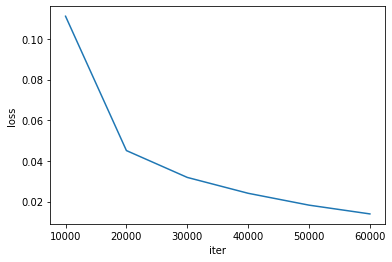

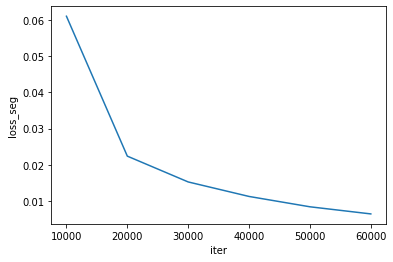

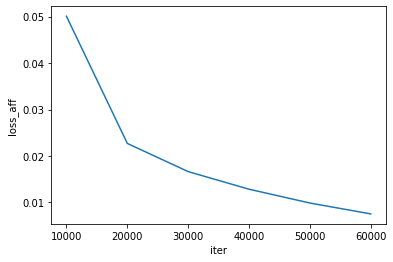

iter:60010, loss:0.0193, loss_seg:0.0075, loss_aff:0.0118
iter:60020, loss:0.0155, loss_seg:0.0074, loss_aff:0.0082
iter:60030, loss:0.0143, loss_seg:0.0060, loss_aff:0.0083
iter:60040, loss:0.0128, loss_seg:0.0058, loss_aff:0.0070
iter:60050, loss:0.0170, loss_seg:0.0074, loss_aff:0.0097
iter:60060, loss:0.0104, loss_seg:0.0033, loss_aff:0.0071
iter:60070, loss:0.0210, loss_seg:0.0093, loss_aff:0.0118
iter:60080, loss:0.0126, loss_seg:0.0057, loss_aff:0.0069
iter:60090, loss:0.0151, loss_seg:0.0070, loss_aff:0.0080
iter:60100, loss:0.0121, loss_seg:0.0058, loss_aff:0.0063
iter:60110, loss:0.0115, loss_seg:0.0051, loss_aff:0.0064
iter:60120, loss:0.0082, loss_seg:0.0048, loss_aff:0.0034
iter:60130, loss:0.0291, loss_seg:0.0136, loss_aff:0.0155
iter:60140, loss:0.0192, loss_seg:0.0087, loss_aff:0.0105
iter:60150, loss:0.0154, loss_seg:0.0066, loss_aff:0.0088
iter:60160, loss:0.0077, loss_seg:0.0036, loss_aff:0.0040
iter:60170, loss:0.0137, loss_seg:0.0052, loss_aff:0.0086
iter:60180, lo

iter:61430, loss:0.0042, loss_seg:0.0023, loss_aff:0.0019
iter:61440, loss:0.0087, loss_seg:0.0040, loss_aff:0.0047
iter:61450, loss:0.0155, loss_seg:0.0058, loss_aff:0.0097
iter:61460, loss:0.0068, loss_seg:0.0028, loss_aff:0.0041
iter:61470, loss:0.0065, loss_seg:0.0032, loss_aff:0.0034
iter:61480, loss:0.0086, loss_seg:0.0032, loss_aff:0.0054
iter:61490, loss:0.0099, loss_seg:0.0048, loss_aff:0.0051
iter:61500, loss:0.0109, loss_seg:0.0050, loss_aff:0.0059
iter:61510, loss:0.0084, loss_seg:0.0037, loss_aff:0.0047
iter:61520, loss:0.0056, loss_seg:0.0028, loss_aff:0.0027
iter:61530, loss:0.0122, loss_seg:0.0059, loss_aff:0.0063
iter:61540, loss:0.0073, loss_seg:0.0040, loss_aff:0.0033
iter:61550, loss:0.0095, loss_seg:0.0042, loss_aff:0.0054
iter:61560, loss:0.0113, loss_seg:0.0059, loss_aff:0.0054
iter:61570, loss:0.0091, loss_seg:0.0046, loss_aff:0.0045
iter:61580, loss:0.0080, loss_seg:0.0036, loss_aff:0.0044
iter:61590, loss:0.0102, loss_seg:0.0044, loss_aff:0.0058
iter:61600, lo

iter:62820, loss:0.0098, loss_seg:0.0033, loss_aff:0.0065
iter:62830, loss:0.0115, loss_seg:0.0064, loss_aff:0.0051
iter:62840, loss:0.0116, loss_seg:0.0057, loss_aff:0.0059
iter:62850, loss:0.0081, loss_seg:0.0040, loss_aff:0.0041
iter:62860, loss:0.0070, loss_seg:0.0031, loss_aff:0.0039
iter:62870, loss:0.0093, loss_seg:0.0040, loss_aff:0.0053
iter:62880, loss:0.0142, loss_seg:0.0061, loss_aff:0.0081
iter:62890, loss:0.0286, loss_seg:0.0051, loss_aff:0.0235
iter:62900, loss:0.0059, loss_seg:0.0029, loss_aff:0.0030
iter:62910, loss:0.0155, loss_seg:0.0058, loss_aff:0.0096
iter:62920, loss:0.0102, loss_seg:0.0046, loss_aff:0.0056
iter:62930, loss:0.0100, loss_seg:0.0051, loss_aff:0.0049
iter:62940, loss:0.0069, loss_seg:0.0030, loss_aff:0.0038
iter:62950, loss:0.0181, loss_seg:0.0072, loss_aff:0.0110
iter:62960, loss:0.0094, loss_seg:0.0053, loss_aff:0.0040
iter:62970, loss:0.0123, loss_seg:0.0046, loss_aff:0.0076
iter:62980, loss:0.0223, loss_seg:0.0114, loss_aff:0.0109
iter:62990, lo

iter:64210, loss:0.0117, loss_seg:0.0054, loss_aff:0.0064
iter:64220, loss:0.0074, loss_seg:0.0039, loss_aff:0.0035
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:64230, loss:0.0109, loss_seg:0.0054, loss_aff:0.0055
iter:64240, loss:0.0093, loss_seg:0.0046, loss_aff:0.0047
iter:64250, loss:0.0082, loss_seg:0.0042, loss_aff:0.0040
iter:64260, loss:0.0146, loss_seg:0.0072, loss_aff:0.0073
iter:64270, loss:0.0075, loss_seg:0.0033, loss_aff:0.0042
iter:64280, loss:0.0089, loss_seg:0.0040, loss_aff:0.0049
iter:64290, loss:0.0141, loss_seg:0.0064, loss_aff:0.0076
iter:64300, loss:0.0146, loss_seg:0.0040, loss_aff:0.0106
iter:64310, loss:0.0141, loss_seg:0.0050, loss_aff:0.0091
iter:64320, loss:0.0066, loss_seg:0.0033, loss_aff:0.0033
iter:64330, loss:0.0138, loss_seg:0.0058, loss_aff:0.0080
iter:64340, loss:0.0128, loss_seg:0.0062, loss_aff:0.0066
iter:64350, loss:0.0095, loss_seg:0.0042, loss_aff

iter:65600, loss:0.0093, loss_seg:0.0047, loss_aff:0.0045
iter:65610, loss:0.0080, loss_seg:0.0044, loss_aff:0.0036
iter:65620, loss:0.0122, loss_seg:0.0056, loss_aff:0.0066
iter:65630, loss:0.0113, loss_seg:0.0048, loss_aff:0.0065
iter:65640, loss:0.0227, loss_seg:0.0110, loss_aff:0.0117
iter:65650, loss:0.0208, loss_seg:0.0088, loss_aff:0.0120
iter:65660, loss:0.0090, loss_seg:0.0040, loss_aff:0.0050
iter:65670, loss:0.0146, loss_seg:0.0078, loss_aff:0.0068
iter:65680, loss:0.0095, loss_seg:0.0036, loss_aff:0.0060
iter:65690, loss:0.0108, loss_seg:0.0048, loss_aff:0.0060
iter:65700, loss:0.0119, loss_seg:0.0060, loss_aff:0.0059
iter:65710, loss:0.0081, loss_seg:0.0037, loss_aff:0.0044
iter:65720, loss:0.0103, loss_seg:0.0047, loss_aff:0.0055
iter:65730, loss:0.0113, loss_seg:0.0061, loss_aff:0.0052
iter:65740, loss:0.0070, loss_seg:0.0036, loss_aff:0.0035
iter:65750, loss:0.0131, loss_seg:0.0063, loss_aff:0.0068
iter:65760, loss:0.0073, loss_seg:0.0033, loss_aff:0.0040
iter:65770, lo

iter:66970, loss:0.0190, loss_seg:0.0107, loss_aff:0.0083
iter:66980, loss:0.0138, loss_seg:0.0064, loss_aff:0.0074
iter:66990, loss:0.0239, loss_seg:0.0116, loss_aff:0.0123
iter:67000, loss:0.0143, loss_seg:0.0070, loss_aff:0.0073
iter:67010, loss:0.0207, loss_seg:0.0098, loss_aff:0.0109
iter:67020, loss:0.0329, loss_seg:0.0174, loss_aff:0.0155
iter:67030, loss:0.0075, loss_seg:0.0029, loss_aff:0.0046
iter:67040, loss:0.0085, loss_seg:0.0039, loss_aff:0.0047
iter:67050, loss:0.0131, loss_seg:0.0063, loss_aff:0.0068
iter:67060, loss:0.0105, loss_seg:0.0047, loss_aff:0.0058
iter:67070, loss:0.0108, loss_seg:0.0042, loss_aff:0.0067
iter:67080, loss:0.0163, loss_seg:0.0072, loss_aff:0.0091
iter:67090, loss:0.0165, loss_seg:0.0077, loss_aff:0.0088
iter:67100, loss:0.0144, loss_seg:0.0052, loss_aff:0.0092
iter:67110, loss:0.0094, loss_seg:0.0044, loss_aff:0.0049
iter:67120, loss:0.0075, loss_seg:0.0039, loss_aff:0.0035
iter:67130, loss:0.0063, loss_seg:0.0027, loss_aff:0.0036
iter:67140, lo

iter:68360, loss:0.0074, loss_seg:0.0040, loss_aff:0.0033
iter:68370, loss:0.0037, loss_seg:0.0021, loss_aff:0.0016
iter:68380, loss:0.0116, loss_seg:0.0042, loss_aff:0.0074
iter:68390, loss:0.0065, loss_seg:0.0035, loss_aff:0.0029
iter:68400, loss:0.0082, loss_seg:0.0043, loss_aff:0.0039
iter:68410, loss:0.0145, loss_seg:0.0043, loss_aff:0.0103
iter:68420, loss:0.0084, loss_seg:0.0041, loss_aff:0.0043
iter:68430, loss:0.0059, loss_seg:0.0034, loss_aff:0.0024
iter:68440, loss:0.0071, loss_seg:0.0032, loss_aff:0.0039
iter:68450, loss:0.0143, loss_seg:0.0030, loss_aff:0.0114
iter:68460, loss:0.0059, loss_seg:0.0034, loss_aff:0.0025
iter:68470, loss:0.0055, loss_seg:0.0034, loss_aff:0.0021
iter:68480, loss:0.0063, loss_seg:0.0028, loss_aff:0.0035
iter:68490, loss:0.0054, loss_seg:0.0028, loss_aff:0.0026
iter:68500, loss:0.0043, loss_seg:0.0025, loss_aff:0.0019
iter:68510, loss:0.0087, loss_seg:0.0041, loss_aff:0.0046
iter:68520, loss:0.0150, loss_seg:0.0071, loss_aff:0.0079
iter:68530, lo

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:69750, loss:0.0120, loss_seg:0.0054, loss_aff:0.0066
iter:69760, loss:0.0072, loss_seg:0.0033, loss_aff:0.0039
iter:69770, loss:0.0085, loss_seg:0.0051, loss_aff:0.0034
iter:69780, loss:0.0100, loss_seg:0.0050, loss_aff:0.0050
iter:69790, loss:0.0062, loss_seg:0.0030, loss_aff:0.0033
iter:69800, loss:0.0136, loss_seg:0.0065, loss_aff:0.0071
iter:69810, loss:0.0079, loss_seg:0.0044, loss_aff:0.0035
iter:69820, loss:0.0143, loss_seg:0.0078, loss_aff:0.0065
iter:69830, loss:0.0323, loss_seg:0.0214, loss_aff:0.0109
iter:69840, loss:0.0119, loss_seg:0.0056, loss_aff:0.0063
iter:69850, loss:0.0102, loss_seg:0.0047, loss_aff:0.0054
iter:69860, loss:0.0122, loss_seg:0.0056, loss_aff:0.0066
iter:69870, loss:0.0323, loss_seg:0.0168, loss_aff:0.0155
iter:69880, loss:0.0230, loss_seg:0.0103, loss_aff:0.0128
iter:69890, loss:0.0120, loss_seg:0.0062, loss_aff

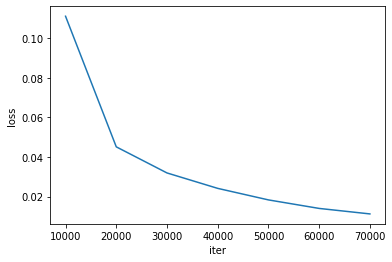

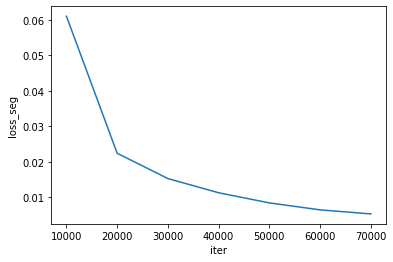

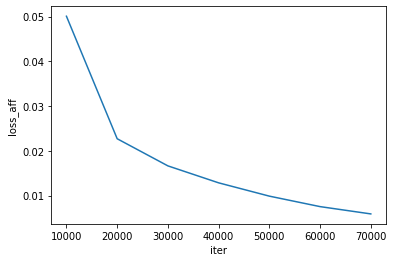

iter:70010, loss:0.0103, loss_seg:0.0050, loss_aff:0.0052
iter:70020, loss:0.0130, loss_seg:0.0056, loss_aff:0.0074
iter:70030, loss:0.0073, loss_seg:0.0038, loss_aff:0.0035
iter:70040, loss:0.0077, loss_seg:0.0036, loss_aff:0.0041
iter:70050, loss:0.0056, loss_seg:0.0026, loss_aff:0.0030
iter:70060, loss:0.0038, loss_seg:0.0024, loss_aff:0.0014
iter:70070, loss:0.0112, loss_seg:0.0049, loss_aff:0.0063
iter:70080, loss:0.0095, loss_seg:0.0056, loss_aff:0.0039
iter:70090, loss:0.0212, loss_seg:0.0150, loss_aff:0.0062
iter:70100, loss:0.0123, loss_seg:0.0057, loss_aff:0.0065
iter:70110, loss:0.0096, loss_seg:0.0051, loss_aff:0.0046
iter:70120, loss:0.0160, loss_seg:0.0056, loss_aff:0.0104
iter:70130, loss:0.0148, loss_seg:0.0066, loss_aff:0.0082
iter:70140, loss:0.0103, loss_seg:0.0047, loss_aff:0.0056
iter:70150, loss:0.0191, loss_seg:0.0074, loss_aff:0.0117
iter:70160, loss:0.0090, loss_seg:0.0044, loss_aff:0.0046
iter:70170, loss:0.0073, loss_seg:0.0040, loss_aff:0.0033
iter:70180, lo

iter:71400, loss:0.0128, loss_seg:0.0061, loss_aff:0.0066
iter:71410, loss:0.0094, loss_seg:0.0044, loss_aff:0.0050
iter:71420, loss:0.0105, loss_seg:0.0036, loss_aff:0.0069
iter:71430, loss:0.0096, loss_seg:0.0042, loss_aff:0.0055
iter:71440, loss:0.0091, loss_seg:0.0038, loss_aff:0.0052
iter:71450, loss:0.0077, loss_seg:0.0040, loss_aff:0.0037
iter:71460, loss:0.0091, loss_seg:0.0020, loss_aff:0.0071
iter:71470, loss:0.0149, loss_seg:0.0078, loss_aff:0.0071
iter:71480, loss:0.0063, loss_seg:0.0038, loss_aff:0.0025
iter:71490, loss:0.0083, loss_seg:0.0037, loss_aff:0.0046
iter:71500, loss:0.0075, loss_seg:0.0037, loss_aff:0.0038
iter:71510, loss:0.0136, loss_seg:0.0064, loss_aff:0.0072
iter:71520, loss:0.0057, loss_seg:0.0027, loss_aff:0.0030
iter:71530, loss:0.0124, loss_seg:0.0055, loss_aff:0.0069
iter:71540, loss:0.0073, loss_seg:0.0035, loss_aff:0.0038
iter:71550, loss:0.0141, loss_seg:0.0073, loss_aff:0.0068
iter:71560, loss:0.0065, loss_seg:0.0037, loss_aff:0.0028
iter:71570, lo

iter:72770, loss:0.0098, loss_seg:0.0054, loss_aff:0.0044
iter:72780, loss:0.0090, loss_seg:0.0039, loss_aff:0.0051
iter:72790, loss:0.0102, loss_seg:0.0057, loss_aff:0.0045
iter:72800, loss:0.0066, loss_seg:0.0032, loss_aff:0.0034
iter:72810, loss:0.0068, loss_seg:0.0038, loss_aff:0.0029
iter:72820, loss:0.0082, loss_seg:0.0034, loss_aff:0.0048
iter:72830, loss:0.0092, loss_seg:0.0044, loss_aff:0.0048
iter:72840, loss:0.0065, loss_seg:0.0019, loss_aff:0.0046
iter:72850, loss:0.0075, loss_seg:0.0042, loss_aff:0.0033
iter:72860, loss:0.0077, loss_seg:0.0039, loss_aff:0.0038
iter:72870, loss:0.0113, loss_seg:0.0043, loss_aff:0.0071
iter:72880, loss:0.0068, loss_seg:0.0031, loss_aff:0.0037
iter:72890, loss:0.0036, loss_seg:0.0020, loss_aff:0.0016
iter:72900, loss:0.0141, loss_seg:0.0051, loss_aff:0.0090
iter:72910, loss:0.0059, loss_seg:0.0035, loss_aff:0.0024
iter:72920, loss:0.0101, loss_seg:0.0054, loss_aff:0.0047
iter:72930, loss:0.0075, loss_seg:0.0044, loss_aff:0.0031
iter:72940, lo

iter:74190, loss:0.0100, loss_seg:0.0047, loss_aff:0.0053
iter:74200, loss:0.0066, loss_seg:0.0032, loss_aff:0.0034
iter:74210, loss:0.0190, loss_seg:0.0104, loss_aff:0.0086
iter:74220, loss:0.0119, loss_seg:0.0051, loss_aff:0.0068
iter:74230, loss:0.0090, loss_seg:0.0038, loss_aff:0.0052
iter:74240, loss:0.0049, loss_seg:0.0022, loss_aff:0.0027
iter:74250, loss:0.0077, loss_seg:0.0040, loss_aff:0.0037
iter:74260, loss:0.0080, loss_seg:0.0039, loss_aff:0.0041
iter:74270, loss:0.0100, loss_seg:0.0040, loss_aff:0.0060
iter:74280, loss:0.0104, loss_seg:0.0062, loss_aff:0.0042
iter:74290, loss:0.0105, loss_seg:0.0046, loss_aff:0.0058
iter:74300, loss:0.0072, loss_seg:0.0034, loss_aff:0.0039
iter:74310, loss:0.0074, loss_seg:0.0040, loss_aff:0.0034
iter:74320, loss:0.0088, loss_seg:0.0040, loss_aff:0.0048
iter:74330, loss:0.0128, loss_seg:0.0059, loss_aff:0.0069
iter:74340, loss:0.0061, loss_seg:0.0029, loss_aff:0.0032
iter:74350, loss:0.0090, loss_seg:0.0047, loss_aff:0.0044
iter:74360, lo

iter:75560, loss:0.0083, loss_seg:0.0048, loss_aff:0.0034
iter:75570, loss:0.0046, loss_seg:0.0026, loss_aff:0.0020
iter:75580, loss:0.0166, loss_seg:0.0085, loss_aff:0.0081
iter:75590, loss:0.0151, loss_seg:0.0072, loss_aff:0.0079
iter:75600, loss:0.0114, loss_seg:0.0048, loss_aff:0.0065
iter:75610, loss:0.0139, loss_seg:0.0077, loss_aff:0.0062
iter:75620, loss:0.0075, loss_seg:0.0031, loss_aff:0.0044
iter:75630, loss:0.0087, loss_seg:0.0043, loss_aff:0.0044
iter:75640, loss:0.0099, loss_seg:0.0042, loss_aff:0.0057
iter:75650, loss:0.0086, loss_seg:0.0041, loss_aff:0.0045
iter:75660, loss:0.0131, loss_seg:0.0055, loss_aff:0.0075
iter:75670, loss:0.0093, loss_seg:0.0042, loss_aff:0.0052
iter:75680, loss:0.0094, loss_seg:0.0041, loss_aff:0.0053
iter:75690, loss:0.0108, loss_seg:0.0049, loss_aff:0.0059
iter:75700, loss:0.0115, loss_seg:0.0056, loss_aff:0.0059
iter:75710, loss:0.0127, loss_seg:0.0076, loss_aff:0.0050
iter:75720, loss:0.0071, loss_seg:0.0035, loss_aff:0.0036
iter:75730, lo

iter:76950, loss:0.0090, loss_seg:0.0042, loss_aff:0.0048
iter:76960, loss:0.0087, loss_seg:0.0048, loss_aff:0.0039
iter:76970, loss:0.0094, loss_seg:0.0056, loss_aff:0.0038
iter:76980, loss:0.0088, loss_seg:0.0036, loss_aff:0.0053
iter:76990, loss:0.0044, loss_seg:0.0021, loss_aff:0.0022
iter:77000, loss:0.0037, loss_seg:0.0022, loss_aff:0.0015
iter:77010, loss:0.0062, loss_seg:0.0021, loss_aff:0.0041
iter:77020, loss:0.0045, loss_seg:0.0023, loss_aff:0.0021
iter:77030, loss:0.0076, loss_seg:0.0043, loss_aff:0.0033
iter:77040, loss:0.0084, loss_seg:0.0042, loss_aff:0.0042
iter:77050, loss:0.0068, loss_seg:0.0037, loss_aff:0.0032
iter:77060, loss:0.0034, loss_seg:0.0018, loss_aff:0.0016
iter:77070, loss:0.0064, loss_seg:0.0039, loss_aff:0.0025
iter:77080, loss:0.0062, loss_seg:0.0029, loss_aff:0.0034
iter:77090, loss:0.0084, loss_seg:0.0042, loss_aff:0.0042
iter:77100, loss:0.0064, loss_seg:0.0030, loss_aff:0.0035
iter:77110, loss:0.0060, loss_seg:0.0034, loss_aff:0.0026
iter:77120, lo

iter:78340, loss:0.0086, loss_seg:0.0043, loss_aff:0.0043
iter:78350, loss:0.0054, loss_seg:0.0028, loss_aff:0.0026
iter:78360, loss:0.0075, loss_seg:0.0036, loss_aff:0.0039
iter:78370, loss:0.0058, loss_seg:0.0030, loss_aff:0.0028
iter:78380, loss:0.0062, loss_seg:0.0031, loss_aff:0.0031
iter:78390, loss:0.0041, loss_seg:0.0024, loss_aff:0.0017
iter:78400, loss:0.0074, loss_seg:0.0036, loss_aff:0.0038
iter:78410, loss:0.0100, loss_seg:0.0047, loss_aff:0.0053
iter:78420, loss:0.0071, loss_seg:0.0032, loss_aff:0.0038
iter:78430, loss:0.0046, loss_seg:0.0027, loss_aff:0.0019
iter:78440, loss:0.0085, loss_seg:0.0040, loss_aff:0.0045
iter:78450, loss:0.0091, loss_seg:0.0042, loss_aff:0.0049
iter:78460, loss:0.0105, loss_seg:0.0045, loss_aff:0.0060
iter:78470, loss:0.0083, loss_seg:0.0041, loss_aff:0.0042
iter:78480, loss:0.0068, loss_seg:0.0033, loss_aff:0.0035
iter:78490, loss:0.0078, loss_seg:0.0044, loss_aff:0.0034
iter:78500, loss:0.0088, loss_seg:0.0046, loss_aff:0.0041
iter:78510, lo

iter:79760, loss:0.0058, loss_seg:0.0032, loss_aff:0.0026
iter:79770, loss:0.0074, loss_seg:0.0042, loss_aff:0.0032
iter:79780, loss:0.0083, loss_seg:0.0039, loss_aff:0.0044
iter:79790, loss:0.0085, loss_seg:0.0045, loss_aff:0.0040
iter:79800, loss:0.0055, loss_seg:0.0027, loss_aff:0.0029
iter:79810, loss:0.0077, loss_seg:0.0037, loss_aff:0.0041
iter:79820, loss:0.0048, loss_seg:0.0024, loss_aff:0.0024
iter:79830, loss:0.0045, loss_seg:0.0023, loss_aff:0.0021
iter:79840, loss:0.0062, loss_seg:0.0033, loss_aff:0.0029
iter:79850, loss:0.0087, loss_seg:0.0036, loss_aff:0.0050
iter:79860, loss:0.0067, loss_seg:0.0042, loss_aff:0.0024
iter:79870, loss:0.0043, loss_seg:0.0025, loss_aff:0.0018
iter:79880, loss:0.0050, loss_seg:0.0029, loss_aff:0.0022
iter:79890, loss:0.0049, loss_seg:0.0029, loss_aff:0.0020
iter:79900, loss:0.0062, loss_seg:0.0033, loss_aff:0.0029
iter:79910, loss:0.0070, loss_seg:0.0034, loss_aff:0.0036
iter:79920, loss:0.0050, loss_seg:0.0029, loss_aff:0.0021
iter:79930, lo

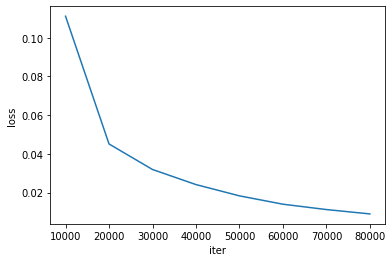

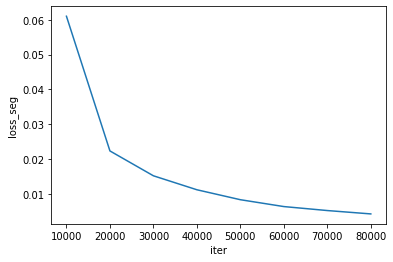

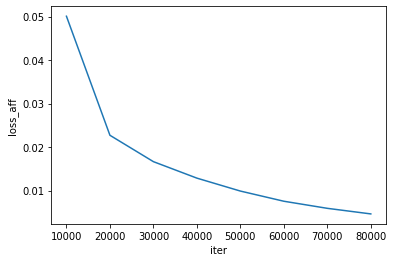

iter:80010, loss:0.0048, loss_seg:0.0028, loss_aff:0.0020
iter:80020, loss:0.0104, loss_seg:0.0045, loss_aff:0.0059
iter:80030, loss:0.0072, loss_seg:0.0038, loss_aff:0.0034
iter:80040, loss:0.0082, loss_seg:0.0038, loss_aff:0.0044
iter:80050, loss:0.0174, loss_seg:0.0088, loss_aff:0.0086
iter:80060, loss:0.0078, loss_seg:0.0046, loss_aff:0.0032
iter:80070, loss:0.0128, loss_seg:0.0063, loss_aff:0.0065
iter:80080, loss:0.0103, loss_seg:0.0047, loss_aff:0.0056
iter:80090, loss:0.0086, loss_seg:0.0043, loss_aff:0.0043
iter:80100, loss:0.0102, loss_seg:0.0054, loss_aff:0.0048
iter:80110, loss:0.0095, loss_seg:0.0045, loss_aff:0.0050
iter:80120, loss:0.0155, loss_seg:0.0096, loss_aff:0.0059
iter:80130, loss:0.0079, loss_seg:0.0032, loss_aff:0.0047
iter:80140, loss:0.0075, loss_seg:0.0037, loss_aff:0.0038
iter:80150, loss:0.0130, loss_seg:0.0029, loss_aff:0.0101
iter:80160, loss:0.0168, loss_seg:0.0082, loss_aff:0.0085
iter:80170, loss:0.0130, loss_seg:0.0066, loss_aff:0.0064
iter:80180, lo

iter:81380, loss:0.0118, loss_seg:0.0048, loss_aff:0.0070
iter:81390, loss:0.0188, loss_seg:0.0071, loss_aff:0.0117
iter:81400, loss:0.0069, loss_seg:0.0034, loss_aff:0.0035
iter:81410, loss:0.0053, loss_seg:0.0027, loss_aff:0.0026
iter:81420, loss:0.0124, loss_seg:0.0066, loss_aff:0.0059
iter:81430, loss:0.0166, loss_seg:0.0090, loss_aff:0.0076
iter:81440, loss:0.0071, loss_seg:0.0026, loss_aff:0.0045
iter:81450, loss:0.0080, loss_seg:0.0040, loss_aff:0.0039
iter:81460, loss:0.0091, loss_seg:0.0033, loss_aff:0.0058
iter:81470, loss:0.0036, loss_seg:0.0019, loss_aff:0.0017
iter:81480, loss:0.0085, loss_seg:0.0046, loss_aff:0.0039
iter:81490, loss:0.0137, loss_seg:0.0027, loss_aff:0.0110
iter:81500, loss:0.0058, loss_seg:0.0028, loss_aff:0.0031
iter:81510, loss:0.0078, loss_seg:0.0035, loss_aff:0.0043
iter:81520, loss:0.0215, loss_seg:0.0112, loss_aff:0.0104
iter:81530, loss:0.0054, loss_seg:0.0028, loss_aff:0.0026
iter:81540, loss:0.0104, loss_seg:0.0051, loss_aff:0.0053
iter:81550, lo

iter:82770, loss:0.0057, loss_seg:0.0030, loss_aff:0.0027
iter:82780, loss:0.0060, loss_seg:0.0032, loss_aff:0.0027
iter:82790, loss:0.0079, loss_seg:0.0036, loss_aff:0.0043
iter:82800, loss:0.0046, loss_seg:0.0024, loss_aff:0.0022
iter:82810, loss:0.0071, loss_seg:0.0033, loss_aff:0.0039
iter:82820, loss:0.0053, loss_seg:0.0029, loss_aff:0.0024
iter:82830, loss:0.0047, loss_seg:0.0027, loss_aff:0.0020
iter:82840, loss:0.0099, loss_seg:0.0053, loss_aff:0.0047
iter:82850, loss:0.0091, loss_seg:0.0044, loss_aff:0.0047
iter:82860, loss:0.0057, loss_seg:0.0031, loss_aff:0.0027
iter:82870, loss:0.0095, loss_seg:0.0048, loss_aff:0.0046
iter:82880, loss:0.0069, loss_seg:0.0038, loss_aff:0.0030
iter:82890, loss:0.0100, loss_seg:0.0045, loss_aff:0.0055
iter:82900, loss:0.0041, loss_seg:0.0021, loss_aff:0.0021
iter:82910, loss:0.0085, loss_seg:0.0042, loss_aff:0.0043
iter:82920, loss:0.0069, loss_seg:0.0032, loss_aff:0.0037
iter:82930, loss:0.0070, loss_seg:0.0035, loss_aff:0.0035
iter:82940, lo

iter:84140, loss:0.0062, loss_seg:0.0033, loss_aff:0.0029
iter:84150, loss:0.0072, loss_seg:0.0032, loss_aff:0.0040
iter:84160, loss:0.0091, loss_seg:0.0039, loss_aff:0.0052
iter:84170, loss:0.0088, loss_seg:0.0037, loss_aff:0.0051
iter:84180, loss:0.0068, loss_seg:0.0031, loss_aff:0.0037
iter:84190, loss:0.0053, loss_seg:0.0028, loss_aff:0.0024
iter:84200, loss:0.0027, loss_seg:0.0016, loss_aff:0.0011
iter:84210, loss:0.0068, loss_seg:0.0038, loss_aff:0.0029
iter:84220, loss:0.0043, loss_seg:0.0020, loss_aff:0.0023
iter:84230, loss:0.0053, loss_seg:0.0026, loss_aff:0.0027
iter:84240, loss:0.0083, loss_seg:0.0041, loss_aff:0.0043
iter:84250, loss:0.0047, loss_seg:0.0026, loss_aff:0.0022
iter:84260, loss:0.0050, loss_seg:0.0027, loss_aff:0.0024
iter:84270, loss:0.0066, loss_seg:0.0032, loss_aff:0.0034
iter:84280, loss:0.0035, loss_seg:0.0019, loss_aff:0.0016
iter:84290, loss:0.0104, loss_seg:0.0057, loss_aff:0.0047
iter:84300, loss:0.0113, loss_seg:0.0057, loss_aff:0.0056
iter:84310, lo

iter:85560, loss:0.0042, loss_seg:0.0022, loss_aff:0.0021
iter:85570, loss:0.0041, loss_seg:0.0022, loss_aff:0.0019
iter:85580, loss:0.0038, loss_seg:0.0020, loss_aff:0.0018
iter:85590, loss:0.0052, loss_seg:0.0029, loss_aff:0.0023
iter:85600, loss:0.0058, loss_seg:0.0031, loss_aff:0.0026
iter:85610, loss:0.0041, loss_seg:0.0025, loss_aff:0.0016
iter:85620, loss:0.0075, loss_seg:0.0035, loss_aff:0.0040
iter:85630, loss:0.0108, loss_seg:0.0051, loss_aff:0.0058
iter:85640, loss:0.0096, loss_seg:0.0046, loss_aff:0.0050
iter:85650, loss:0.0059, loss_seg:0.0036, loss_aff:0.0023
iter:85660, loss:0.0053, loss_seg:0.0019, loss_aff:0.0034
iter:85670, loss:0.0057, loss_seg:0.0027, loss_aff:0.0029
iter:85680, loss:0.0077, loss_seg:0.0034, loss_aff:0.0042
iter:85690, loss:0.0043, loss_seg:0.0022, loss_aff:0.0021
iter:85700, loss:0.0036, loss_seg:0.0020, loss_aff:0.0016
iter:85710, loss:0.0055, loss_seg:0.0027, loss_aff:0.0028
iter:85720, loss:0.0063, loss_seg:0.0024, loss_aff:0.0038
iter:85730, lo

iter:86950, loss:0.0064, loss_seg:0.0033, loss_aff:0.0031
iter:86960, loss:0.0075, loss_seg:0.0038, loss_aff:0.0037
iter:86970, loss:0.0040, loss_seg:0.0019, loss_aff:0.0022
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:86980, loss:0.0087, loss_seg:0.0049, loss_aff:0.0038
iter:86990, loss:0.0104, loss_seg:0.0056, loss_aff:0.0049
iter:87000, loss:0.0134, loss_seg:0.0066, loss_aff:0.0067
iter:87010, loss:0.0150, loss_seg:0.0074, loss_aff:0.0076
iter:87020, loss:0.0119, loss_seg:0.0057, loss_aff:0.0063
iter:87030, loss:0.0208, loss_seg:0.0120, loss_aff:0.0088
iter:87040, loss:0.0100, loss_seg:0.0046, loss_aff:0.0054
iter:87050, loss:0.0102, loss_seg:0.0044, loss_aff:0.0057
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:87060, loss:0.0077, loss_seg:0.0037, loss_aff:0.0040
iter:87070, loss:0.0053, loss

iter:88300, loss:0.0050, loss_seg:0.0028, loss_aff:0.0022
iter:88310, loss:0.0082, loss_seg:0.0042, loss_aff:0.0040
iter:88320, loss:0.0075, loss_seg:0.0029, loss_aff:0.0045
iter:88330, loss:0.0050, loss_seg:0.0024, loss_aff:0.0027
iter:88340, loss:0.0029, loss_seg:0.0018, loss_aff:0.0012
iter:88350, loss:0.0041, loss_seg:0.0016, loss_aff:0.0025
iter:88360, loss:0.0083, loss_seg:0.0030, loss_aff:0.0053
iter:88370, loss:0.0034, loss_seg:0.0018, loss_aff:0.0015
iter:88380, loss:0.0075, loss_seg:0.0041, loss_aff:0.0033
iter:88390, loss:0.0035, loss_seg:0.0020, loss_aff:0.0015
iter:88400, loss:0.0064, loss_seg:0.0034, loss_aff:0.0030
iter:88410, loss:0.0046, loss_seg:0.0023, loss_aff:0.0023
iter:88420, loss:0.0055, loss_seg:0.0028, loss_aff:0.0027
iter:88430, loss:0.0039, loss_seg:0.0021, loss_aff:0.0018
iter:88440, loss:0.0043, loss_seg:0.0022, loss_aff:0.0021
iter:88450, loss:0.0047, loss_seg:0.0024, loss_aff:0.0024
iter:88460, loss:0.0030, loss_seg:0.0018, loss_aff:0.0012
iter:88470, lo

iter:89720, loss:0.0067, loss_seg:0.0039, loss_aff:0.0027
iter:89730, loss:0.0040, loss_seg:0.0024, loss_aff:0.0016
iter:89740, loss:0.0062, loss_seg:0.0031, loss_aff:0.0031
iter:89750, loss:0.0042, loss_seg:0.0023, loss_aff:0.0020
iter:89760, loss:0.0073, loss_seg:0.0038, loss_aff:0.0036
iter:89770, loss:0.0091, loss_seg:0.0049, loss_aff:0.0042
iter:89780, loss:0.0030, loss_seg:0.0017, loss_aff:0.0013
iter:89790, loss:0.0108, loss_seg:0.0056, loss_aff:0.0051
iter:89800, loss:0.0074, loss_seg:0.0038, loss_aff:0.0036
iter:89810, loss:0.0095, loss_seg:0.0046, loss_aff:0.0049
iter:89820, loss:0.0050, loss_seg:0.0028, loss_aff:0.0022
iter:89830, loss:0.0063, loss_seg:0.0030, loss_aff:0.0033
iter:89840, loss:0.0065, loss_seg:0.0035, loss_aff:0.0031
iter:89850, loss:0.0058, loss_seg:0.0035, loss_aff:0.0024
iter:89860, loss:0.0045, loss_seg:0.0027, loss_aff:0.0018
iter:89870, loss:0.0027, loss_seg:0.0015, loss_aff:0.0012
iter:89880, loss:0.0037, loss_seg:0.0020, loss_aff:0.0016
iter:89890, lo

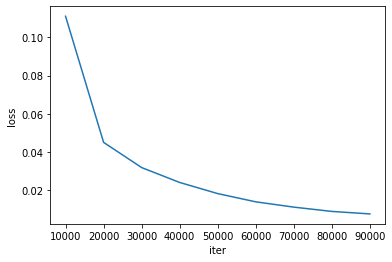

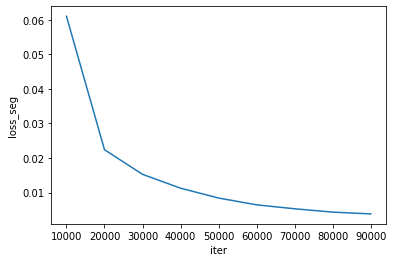

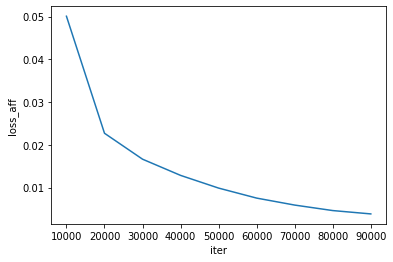

iter:90010, loss:0.0082, loss_seg:0.0047, loss_aff:0.0035
iter:90020, loss:0.0059, loss_seg:0.0037, loss_aff:0.0022
iter:90030, loss:0.0030, loss_seg:0.0018, loss_aff:0.0012
iter:90040, loss:0.0038, loss_seg:0.0021, loss_aff:0.0017
iter:90050, loss:0.0078, loss_seg:0.0030, loss_aff:0.0047
iter:90060, loss:0.0035, loss_seg:0.0016, loss_aff:0.0018
iter:90070, loss:0.0049, loss_seg:0.0025, loss_aff:0.0024
iter:90080, loss:0.0038, loss_seg:0.0024, loss_aff:0.0014
iter:90090, loss:0.0067, loss_seg:0.0026, loss_aff:0.0041
iter:90100, loss:0.0061, loss_seg:0.0033, loss_aff:0.0028
iter:90110, loss:0.0042, loss_seg:0.0024, loss_aff:0.0017
iter:90120, loss:0.0034, loss_seg:0.0018, loss_aff:0.0017
iter:90130, loss:0.0028, loss_seg:0.0014, loss_aff:0.0015
iter:90140, loss:0.0084, loss_seg:0.0051, loss_aff:0.0032
iter:90150, loss:0.0061, loss_seg:0.0030, loss_aff:0.0030
iter:90160, loss:0.0061, loss_seg:0.0033, loss_aff:0.0028
iter:90170, loss:0.0040, loss_seg:0.0024, loss_aff:0.0015
iter:90180, lo

iter:91380, loss:0.0058, loss_seg:0.0025, loss_aff:0.0032
iter:91390, loss:0.0052, loss_seg:0.0020, loss_aff:0.0032
iter:91400, loss:0.0063, loss_seg:0.0033, loss_aff:0.0030
iter:91410, loss:0.0076, loss_seg:0.0050, loss_aff:0.0025
iter:91420, loss:0.0071, loss_seg:0.0039, loss_aff:0.0033
iter:91430, loss:0.0095, loss_seg:0.0046, loss_aff:0.0049
iter:91440, loss:0.0061, loss_seg:0.0030, loss_aff:0.0032
iter:91450, loss:0.0031, loss_seg:0.0016, loss_aff:0.0014
iter:91460, loss:0.0062, loss_seg:0.0036, loss_aff:0.0026
iter:91470, loss:0.0057, loss_seg:0.0031, loss_aff:0.0026
iter:91480, loss:0.0034, loss_seg:0.0017, loss_aff:0.0016
iter:91490, loss:0.0055, loss_seg:0.0030, loss_aff:0.0025
iter:91500, loss:0.0042, loss_seg:0.0023, loss_aff:0.0019
iter:91510, loss:0.0065, loss_seg:0.0031, loss_aff:0.0035
iter:91520, loss:0.0060, loss_seg:0.0026, loss_aff:0.0034
iter:91530, loss:0.0038, loss_seg:0.0020, loss_aff:0.0018
iter:91540, loss:0.0062, loss_seg:0.0035, loss_aff:0.0027
iter:91550, lo

iter:92770, loss:0.0048, loss_seg:0.0028, loss_aff:0.0021
iter:92780, loss:0.0052, loss_seg:0.0022, loss_aff:0.0030
iter:92790, loss:0.0051, loss_seg:0.0028, loss_aff:0.0023
iter:92800, loss:0.0053, loss_seg:0.0029, loss_aff:0.0025
iter:92810, loss:0.0054, loss_seg:0.0030, loss_aff:0.0024
iter:92820, loss:0.0029, loss_seg:0.0013, loss_aff:0.0015
iter:92830, loss:0.0043, loss_seg:0.0024, loss_aff:0.0019
iter:92840, loss:0.0097, loss_seg:0.0044, loss_aff:0.0053
iter:92850, loss:0.0066, loss_seg:0.0036, loss_aff:0.0030
iter:92860, loss:0.0077, loss_seg:0.0039, loss_aff:0.0038
iter:92870, loss:0.0069, loss_seg:0.0035, loss_aff:0.0033
iter:92880, loss:0.0060, loss_seg:0.0038, loss_aff:0.0022
iter:92890, loss:0.0054, loss_seg:0.0035, loss_aff:0.0019
iter:92900, loss:0.0050, loss_seg:0.0025, loss_aff:0.0025
iter:92910, loss:0.0062, loss_seg:0.0036, loss_aff:0.0026
iter:92920, loss:0.0042, loss_seg:0.0026, loss_aff:0.0016
iter:92930, loss:0.0036, loss_seg:0.0020, loss_aff:0.0016
iter:92940, lo

iter:94190, loss:0.0068, loss_seg:0.0038, loss_aff:0.0030
iter:94200, loss:0.0049, loss_seg:0.0025, loss_aff:0.0024
iter:94210, loss:0.0047, loss_seg:0.0027, loss_aff:0.0020
iter:94220, loss:0.0031, loss_seg:0.0017, loss_aff:0.0014
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:94230, loss:0.0038, loss_seg:0.0021, loss_aff:0.0017
iter:94240, loss:0.0048, loss_seg:0.0026, loss_aff:0.0022
iter:94250, loss:0.0029, loss_seg:0.0018, loss_aff:0.0011
iter:94260, loss:0.0065, loss_seg:0.0037, loss_aff:0.0029
iter:94270, loss:0.0067, loss_seg:0.0040, loss_aff:0.0028
iter:94280, loss:0.0033, loss_seg:0.0020, loss_aff:0.0013
iter:94290, loss:0.0040, loss_seg:0.0023, loss_aff:0.0017
iter:94300, loss:0.0040, loss_seg:0.0021, loss_aff:0.0019
iter:94310, loss:0.0030, loss_seg:0.0018, loss_aff:0.0012
iter:94320, loss:0.0076, loss_seg:0.0041, loss_aff:0.0035
iter:94330, loss:0.0075, loss_seg:0.0038, loss_aff:

iter:95560, loss:0.0068, loss_seg:0.0025, loss_aff:0.0042
iter:95570, loss:0.0080, loss_seg:0.0039, loss_aff:0.0041
iter:95580, loss:0.0073, loss_seg:0.0032, loss_aff:0.0041
iter:95590, loss:0.0044, loss_seg:0.0020, loss_aff:0.0024
iter:95600, loss:0.0054, loss_seg:0.0029, loss_aff:0.0025
iter:95610, loss:0.0052, loss_seg:0.0027, loss_aff:0.0025
iter:95620, loss:0.0045, loss_seg:0.0025, loss_aff:0.0020
iter:95630, loss:0.0085, loss_seg:0.0042, loss_aff:0.0042
iter:95640, loss:0.0070, loss_seg:0.0038, loss_aff:0.0032
iter:95650, loss:0.0178, loss_seg:0.0093, loss_aff:0.0085
iter:95660, loss:0.0059, loss_seg:0.0025, loss_aff:0.0035
iter:95670, loss:0.0103, loss_seg:0.0039, loss_aff:0.0063
iter:95680, loss:0.0040, loss_seg:0.0024, loss_aff:0.0016
iter:95690, loss:0.0050, loss_seg:0.0027, loss_aff:0.0023
iter:95700, loss:0.0040, loss_seg:0.0021, loss_aff:0.0019
iter:95710, loss:0.0071, loss_seg:0.0019, loss_aff:0.0052
iter:95720, loss:0.0120, loss_seg:0.0066, loss_aff:0.0054
iter:95730, lo

iter:96950, loss:0.0043, loss_seg:0.0026, loss_aff:0.0017
iter:96960, loss:0.0028, loss_seg:0.0013, loss_aff:0.0015
iter:96970, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:96980, loss:0.0043, loss_seg:0.0025, loss_aff:0.0018
iter:96990, loss:0.0036, loss_seg:0.0019, loss_aff:0.0017
iter:97000, loss:0.0083, loss_seg:0.0032, loss_aff:0.0051
iter:97010, loss:0.0046, loss_seg:0.0021, loss_aff:0.0024
iter:97020, loss:0.0110, loss_seg:0.0054, loss_aff:0.0055
iter:97030, loss:0.0037, loss_seg:0.0019, loss_aff:0.0017
iter:97040, loss:0.0033, loss_seg:0.0020, loss_aff:0.0013
iter:97050, loss:0.0036, loss_seg:0.0020, loss_aff:0.0017
iter:97060, loss:0.0049, loss_seg:0.0029, loss_aff:0.0020
iter:97070, loss:0.0048, loss_seg:0.0021, loss_aff:0.0027
iter:97080, loss:0.0034, loss_seg:0.0021, loss_aff:0.0013
iter:97090, loss:0.0065, loss_seg:0.0020, loss_aff:0.0045
iter:97100, loss:0.0042, loss_seg:0.0021, loss_aff:0.0020
iter:97110, loss:0.0082, loss_seg:0.0050, loss_aff:0.0032
iter:97120, lo

iter:98320, loss:0.0058, loss_seg:0.0033, loss_aff:0.0024
iter:98330, loss:0.0087, loss_seg:0.0034, loss_aff:0.0052
iter:98340, loss:0.0082, loss_seg:0.0017, loss_aff:0.0065
iter:98350, loss:0.0079, loss_seg:0.0043, loss_aff:0.0036
iter:98360, loss:0.0057, loss_seg:0.0032, loss_aff:0.0025
iter:98370, loss:0.0037, loss_seg:0.0024, loss_aff:0.0013
iter:98380, loss:0.0030, loss_seg:0.0017, loss_aff:0.0013
iter:98390, loss:0.0056, loss_seg:0.0035, loss_aff:0.0022
iter:98400, loss:0.0054, loss_seg:0.0029, loss_aff:0.0025
iter:98410, loss:0.0081, loss_seg:0.0049, loss_aff:0.0032
iter:98420, loss:0.0036, loss_seg:0.0015, loss_aff:0.0021
iter:98430, loss:0.0094, loss_seg:0.0042, loss_aff:0.0052
iter:98440, loss:0.0048, loss_seg:0.0028, loss_aff:0.0020
iter:98450, loss:0.0058, loss_seg:0.0029, loss_aff:0.0029
iter:98460, loss:0.0092, loss_seg:0.0041, loss_aff:0.0052
iter:98470, loss:0.0101, loss_seg:0.0039, loss_aff:0.0061
iter:98480, loss:0.0045, loss_seg:0.0029, loss_aff:0.0016
iter:98490, lo

iter:99710, loss:0.0049, loss_seg:0.0025, loss_aff:0.0024
iter:99720, loss:0.0045, loss_seg:0.0021, loss_aff:0.0023
iter:99730, loss:0.0035, loss_seg:0.0020, loss_aff:0.0015
iter:99740, loss:0.0047, loss_seg:0.0026, loss_aff:0.0021
iter:99750, loss:0.0048, loss_seg:0.0026, loss_aff:0.0022
iter:99760, loss:0.0048, loss_seg:0.0022, loss_aff:0.0026
iter:99770, loss:0.0043, loss_seg:0.0016, loss_aff:0.0027
iter:99780, loss:0.0041, loss_seg:0.0022, loss_aff:0.0019
iter:99790, loss:0.0092, loss_seg:0.0051, loss_aff:0.0041
iter:99800, loss:0.0048, loss_seg:0.0029, loss_aff:0.0019
iter:99810, loss:0.0029, loss_seg:0.0018, loss_aff:0.0011
iter:99820, loss:0.0035, loss_seg:0.0018, loss_aff:0.0017
iter:99830, loss:0.0026, loss_seg:0.0016, loss_aff:0.0010
iter:99840, loss:0.0065, loss_seg:0.0038, loss_aff:0.0027
iter:99850, loss:0.0028, loss_seg:0.0016, loss_aff:0.0012
iter:99860, loss:0.0029, loss_seg:0.0016, loss_aff:0.0012
iter:99870, loss:0.0026, loss_seg:0.0015, loss_aff:0.0011
iter:99880, lo

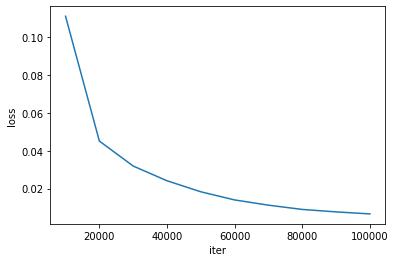

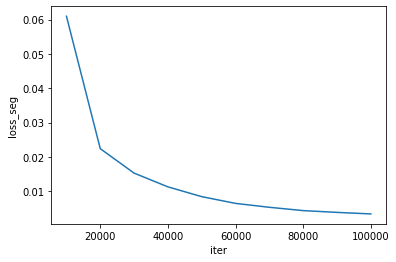

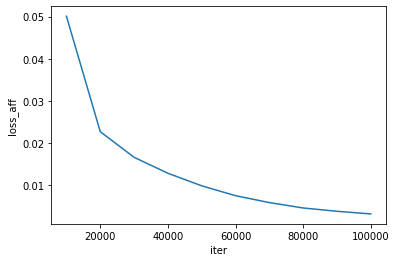

iter:100010, loss:0.0052, loss_seg:0.0029, loss_aff:0.0024
iter:100020, loss:0.0043, loss_seg:0.0026, loss_aff:0.0016
iter:100030, loss:0.0045, loss_seg:0.0026, loss_aff:0.0019
iter:100040, loss:0.0049, loss_seg:0.0025, loss_aff:0.0024
iter:100050, loss:0.0068, loss_seg:0.0028, loss_aff:0.0040
iter:100060, loss:0.0045, loss_seg:0.0026, loss_aff:0.0019
iter:100070, loss:0.0069, loss_seg:0.0038, loss_aff:0.0031
iter:100080, loss:0.0044, loss_seg:0.0022, loss_aff:0.0023
iter:100090, loss:0.0051, loss_seg:0.0023, loss_aff:0.0028
iter:100100, loss:0.0053, loss_seg:0.0029, loss_aff:0.0024
iter:100110, loss:0.0065, loss_seg:0.0033, loss_aff:0.0032
iter:100120, loss:0.0082, loss_seg:0.0045, loss_aff:0.0037
iter:100130, loss:0.0055, loss_seg:0.0033, loss_aff:0.0022
iter:100140, loss:0.0040, loss_seg:0.0024, loss_aff:0.0016
iter:100150, loss:0.0066, loss_seg:0.0032, loss_aff:0.0034
iter:100160, loss:0.0055, loss_seg:0.0028, loss_aff:0.0027
iter:100170, loss:0.0027, loss_seg:0.0013, loss_aff:0.00

iter:101380, loss:0.0033, loss_seg:0.0017, loss_aff:0.0016
iter:101390, loss:0.0023, loss_seg:0.0013, loss_aff:0.0010
iter:101400, loss:0.0097, loss_seg:0.0047, loss_aff:0.0050
iter:101410, loss:0.0120, loss_seg:0.0064, loss_aff:0.0056
iter:101420, loss:0.0095, loss_seg:0.0056, loss_aff:0.0039
iter:101430, loss:0.0093, loss_seg:0.0052, loss_aff:0.0041
iter:101440, loss:0.0101, loss_seg:0.0041, loss_aff:0.0060
iter:101450, loss:0.0054, loss_seg:0.0029, loss_aff:0.0025
iter:101460, loss:0.0338, loss_seg:0.0259, loss_aff:0.0079
iter:101470, loss:0.0225, loss_seg:0.0126, loss_aff:0.0098
iter:101480, loss:0.0118, loss_seg:0.0052, loss_aff:0.0066
iter:101490, loss:0.0115, loss_seg:0.0061, loss_aff:0.0054
iter:101500, loss:0.0064, loss_seg:0.0029, loss_aff:0.0036
iter:101510, loss:0.0115, loss_seg:0.0072, loss_aff:0.0042
iter:101520, loss:0.0092, loss_seg:0.0047, loss_aff:0.0045
iter:101530, loss:0.0074, loss_seg:0.0034, loss_aff:0.0040
iter:101540, loss:0.0081, loss_seg:0.0043, loss_aff:0.00

iter:102750, loss:0.0071, loss_seg:0.0033, loss_aff:0.0038
iter:102760, loss:0.0082, loss_seg:0.0039, loss_aff:0.0044
iter:102770, loss:0.0051, loss_seg:0.0028, loss_aff:0.0024
iter:102780, loss:0.0062, loss_seg:0.0025, loss_aff:0.0037
iter:102790, loss:0.0040, loss_seg:0.0018, loss_aff:0.0021
iter:102800, loss:0.0062, loss_seg:0.0035, loss_aff:0.0027
iter:102810, loss:0.0053, loss_seg:0.0019, loss_aff:0.0035
iter:102820, loss:0.0040, loss_seg:0.0020, loss_aff:0.0019
iter:102830, loss:0.0088, loss_seg:0.0051, loss_aff:0.0036
iter:102840, loss:0.0038, loss_seg:0.0022, loss_aff:0.0016
iter:102850, loss:0.0124, loss_seg:0.0069, loss_aff:0.0055
iter:102860, loss:0.0061, loss_seg:0.0029, loss_aff:0.0033
iter:102870, loss:0.0075, loss_seg:0.0031, loss_aff:0.0044
iter:102880, loss:0.0033, loss_seg:0.0020, loss_aff:0.0013
iter:102890, loss:0.0084, loss_seg:0.0042, loss_aff:0.0042
iter:102900, loss:0.0050, loss_seg:0.0029, loss_aff:0.0021
iter:102910, loss:0.0046, loss_seg:0.0020, loss_aff:0.00

iter:104100, loss:0.0044, loss_seg:0.0019, loss_aff:0.0025
iter:104110, loss:0.0040, loss_seg:0.0026, loss_aff:0.0013
iter:104120, loss:0.0032, loss_seg:0.0017, loss_aff:0.0014
iter:104130, loss:0.0058, loss_seg:0.0037, loss_aff:0.0021
iter:104140, loss:0.0028, loss_seg:0.0015, loss_aff:0.0012
iter:104150, loss:0.0042, loss_seg:0.0025, loss_aff:0.0017
iter:104160, loss:0.0031, loss_seg:0.0020, loss_aff:0.0011
iter:104170, loss:0.0055, loss_seg:0.0027, loss_aff:0.0028
iter:104180, loss:0.0026, loss_seg:0.0017, loss_aff:0.0009
iter:104190, loss:0.0040, loss_seg:0.0025, loss_aff:0.0014
iter:104200, loss:0.0038, loss_seg:0.0023, loss_aff:0.0015
iter:104210, loss:0.0033, loss_seg:0.0022, loss_aff:0.0011
iter:104220, loss:0.0048, loss_seg:0.0026, loss_aff:0.0022
iter:104230, loss:0.0026, loss_seg:0.0014, loss_aff:0.0012
iter:104240, loss:0.0042, loss_seg:0.0021, loss_aff:0.0021
iter:104250, loss:0.0081, loss_seg:0.0052, loss_aff:0.0028
iter:104260, loss:0.0041, loss_seg:0.0017, loss_aff:0.00

iter:105490, loss:0.0057, loss_seg:0.0029, loss_aff:0.0029
iter:105500, loss:0.0040, loss_seg:0.0020, loss_aff:0.0020
iter:105510, loss:0.0077, loss_seg:0.0032, loss_aff:0.0045
iter:105520, loss:0.0046, loss_seg:0.0026, loss_aff:0.0020
iter:105530, loss:0.0049, loss_seg:0.0026, loss_aff:0.0022
iter:105540, loss:0.0036, loss_seg:0.0020, loss_aff:0.0017
iter:105550, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:105560, loss:0.0062, loss_seg:0.0033, loss_aff:0.0029
iter:105570, loss:0.0090, loss_seg:0.0036, loss_aff:0.0054
iter:105580, loss:0.0107, loss_seg:0.0065, loss_aff:0.0042
iter:105590, loss:0.0046, loss_seg:0.0027, loss_aff:0.0019
iter:105600, loss:0.0155, loss_seg:0.0110, loss_aff:0.0045
iter:105610, loss:0.0101, loss_seg:0.0058, loss_aff:0.0043
iter:105620, loss:0.0080, loss_seg:0.0039, loss_aff:0.0041
iter:105630, loss:0.0158, loss_seg:0.0081, loss_aff:0.0077
iter:105640, loss:0.0178, loss_seg:0.0092, loss_aff:0.0085
iter:105650, loss:0.0109, loss_seg:0.0057, loss_aff:0.00

iter:106860, loss:0.0265, loss_seg:0.0218, loss_aff:0.0048
iter:106870, loss:0.0054, loss_seg:0.0028, loss_aff:0.0025
iter:106880, loss:0.0037, loss_seg:0.0020, loss_aff:0.0016
iter:106890, loss:0.0054, loss_seg:0.0023, loss_aff:0.0030
iter:106900, loss:0.0047, loss_seg:0.0024, loss_aff:0.0023
iter:106910, loss:0.0052, loss_seg:0.0028, loss_aff:0.0024
iter:106920, loss:0.0048, loss_seg:0.0023, loss_aff:0.0025
iter:106930, loss:0.0039, loss_seg:0.0019, loss_aff:0.0020
iter:106940, loss:0.0046, loss_seg:0.0023, loss_aff:0.0023
iter:106950, loss:0.0059, loss_seg:0.0032, loss_aff:0.0028
iter:106960, loss:0.0066, loss_seg:0.0031, loss_aff:0.0035
iter:106970, loss:0.0052, loss_seg:0.0033, loss_aff:0.0018
iter:106980, loss:0.0038, loss_seg:0.0019, loss_aff:0.0020
iter:106990, loss:0.0054, loss_seg:0.0026, loss_aff:0.0028
iter:107000, loss:0.0031, loss_seg:0.0018, loss_aff:0.0012
iter:107010, loss:0.0054, loss_seg:0.0029, loss_aff:0.0025
iter:107020, loss:0.0047, loss_seg:0.0024, loss_aff:0.00

iter:108230, loss:0.0127, loss_seg:0.0070, loss_aff:0.0056
iter:108240, loss:0.0044, loss_seg:0.0027, loss_aff:0.0016
iter:108250, loss:0.0018, loss_seg:0.0010, loss_aff:0.0007
iter:108260, loss:0.0036, loss_seg:0.0021, loss_aff:0.0014
iter:108270, loss:0.0050, loss_seg:0.0028, loss_aff:0.0022
iter:108280, loss:0.0041, loss_seg:0.0023, loss_aff:0.0018
iter:108290, loss:0.0050, loss_seg:0.0030, loss_aff:0.0020
iter:108300, loss:0.0053, loss_seg:0.0023, loss_aff:0.0031
iter:108310, loss:0.0078, loss_seg:0.0044, loss_aff:0.0034
iter:108320, loss:0.0027, loss_seg:0.0017, loss_aff:0.0010
iter:108330, loss:0.0037, loss_seg:0.0018, loss_aff:0.0019
iter:108340, loss:0.0034, loss_seg:0.0018, loss_aff:0.0016
iter:108350, loss:0.0022, loss_seg:0.0012, loss_aff:0.0009
iter:108360, loss:0.0034, loss_seg:0.0022, loss_aff:0.0012
iter:108370, loss:0.0031, loss_seg:0.0019, loss_aff:0.0012
iter:108380, loss:0.0033, loss_seg:0.0020, loss_aff:0.0013
iter:108390, loss:0.0026, loss_seg:0.0017, loss_aff:0.00

iter:109600, loss:0.0030, loss_seg:0.0019, loss_aff:0.0011
iter:109610, loss:0.0034, loss_seg:0.0016, loss_aff:0.0018
iter:109620, loss:0.0032, loss_seg:0.0016, loss_aff:0.0016
iter:109630, loss:0.0054, loss_seg:0.0035, loss_aff:0.0019
iter:109640, loss:0.0077, loss_seg:0.0012, loss_aff:0.0065
iter:109650, loss:0.0023, loss_seg:0.0013, loss_aff:0.0010
iter:109660, loss:0.0038, loss_seg:0.0022, loss_aff:0.0016
iter:109670, loss:0.0060, loss_seg:0.0034, loss_aff:0.0026
iter:109680, loss:0.0057, loss_seg:0.0038, loss_aff:0.0020
iter:109690, loss:0.0032, loss_seg:0.0018, loss_aff:0.0014
iter:109700, loss:0.0031, loss_seg:0.0018, loss_aff:0.0013
iter:109710, loss:0.0030, loss_seg:0.0013, loss_aff:0.0016
iter:109720, loss:0.0030, loss_seg:0.0018, loss_aff:0.0012
iter:109730, loss:0.0048, loss_seg:0.0026, loss_aff:0.0022
iter:109740, loss:0.0039, loss_seg:0.0015, loss_aff:0.0024
iter:109750, loss:0.0068, loss_seg:0.0032, loss_aff:0.0035
iter:109760, loss:0.0045, loss_seg:0.0020, loss_aff:0.00

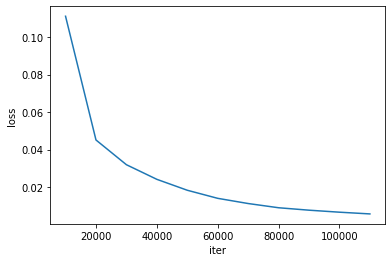

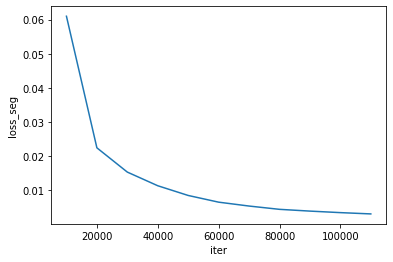

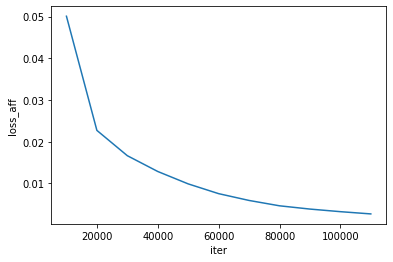

iter:110010, loss:0.0043, loss_seg:0.0025, loss_aff:0.0018
iter:110020, loss:0.0039, loss_seg:0.0018, loss_aff:0.0021
iter:110030, loss:0.0063, loss_seg:0.0027, loss_aff:0.0036
iter:110040, loss:0.0034, loss_seg:0.0021, loss_aff:0.0014
iter:110050, loss:0.0046, loss_seg:0.0027, loss_aff:0.0019
iter:110060, loss:0.0101, loss_seg:0.0046, loss_aff:0.0055
iter:110070, loss:0.0048, loss_seg:0.0020, loss_aff:0.0028
iter:110080, loss:0.0056, loss_seg:0.0032, loss_aff:0.0024
iter:110090, loss:0.0055, loss_seg:0.0029, loss_aff:0.0026
iter:110100, loss:0.0029, loss_seg:0.0017, loss_aff:0.0012
iter:110110, loss:0.0039, loss_seg:0.0024, loss_aff:0.0015
iter:110120, loss:0.0037, loss_seg:0.0018, loss_aff:0.0018
iter:110130, loss:0.0035, loss_seg:0.0016, loss_aff:0.0019
iter:110140, loss:0.0056, loss_seg:0.0029, loss_aff:0.0026
iter:110150, loss:0.0040, loss_seg:0.0027, loss_aff:0.0013
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_sp

iter:111360, loss:0.0085, loss_seg:0.0046, loss_aff:0.0040
iter:111370, loss:0.0105, loss_seg:0.0066, loss_aff:0.0038
iter:111380, loss:0.0034, loss_seg:0.0018, loss_aff:0.0016
iter:111390, loss:0.0085, loss_seg:0.0041, loss_aff:0.0044
iter:111400, loss:0.0065, loss_seg:0.0035, loss_aff:0.0030
iter:111410, loss:0.0041, loss_seg:0.0020, loss_aff:0.0022
iter:111420, loss:0.0041, loss_seg:0.0025, loss_aff:0.0017
iter:111430, loss:0.0035, loss_seg:0.0018, loss_aff:0.0017
iter:111440, loss:0.0080, loss_seg:0.0029, loss_aff:0.0051
iter:111450, loss:0.0042, loss_seg:0.0022, loss_aff:0.0020
iter:111460, loss:0.0036, loss_seg:0.0020, loss_aff:0.0017
iter:111470, loss:0.0032, loss_seg:0.0017, loss_aff:0.0015
iter:111480, loss:0.0081, loss_seg:0.0040, loss_aff:0.0041
iter:111490, loss:0.0039, loss_seg:0.0025, loss_aff:0.0013
iter:111500, loss:0.0037, loss_seg:0.0023, loss_aff:0.0014
iter:111510, loss:0.0056, loss_seg:0.0034, loss_aff:0.0022
iter:111520, loss:0.0028, loss_seg:0.0013, loss_aff:0.00

iter:112710, loss:0.0032, loss_seg:0.0017, loss_aff:0.0015
iter:112720, loss:0.0024, loss_seg:0.0016, loss_aff:0.0009
iter:112730, loss:0.0026, loss_seg:0.0017, loss_aff:0.0010
iter:112740, loss:0.0041, loss_seg:0.0025, loss_aff:0.0016
iter:112750, loss:0.0025, loss_seg:0.0014, loss_aff:0.0011
iter:112760, loss:0.0041, loss_seg:0.0020, loss_aff:0.0020
iter:112770, loss:0.0040, loss_seg:0.0025, loss_aff:0.0015
iter:112780, loss:0.0134, loss_seg:0.0074, loss_aff:0.0060
iter:112790, loss:0.0076, loss_seg:0.0036, loss_aff:0.0040
iter:112800, loss:0.0037, loss_seg:0.0021, loss_aff:0.0016
iter:112810, loss:0.0048, loss_seg:0.0026, loss_aff:0.0022
iter:112820, loss:0.0147, loss_seg:0.0090, loss_aff:0.0056
iter:112830, loss:0.0058, loss_seg:0.0034, loss_aff:0.0024
iter:112840, loss:0.0091, loss_seg:0.0045, loss_aff:0.0045
iter:112850, loss:0.0134, loss_seg:0.0062, loss_aff:0.0072
iter:112860, loss:0.0141, loss_seg:0.0077, loss_aff:0.0064
iter:112870, loss:0.0223, loss_seg:0.0147, loss_aff:0.00

iter:114100, loss:0.0059, loss_seg:0.0036, loss_aff:0.0023
iter:114110, loss:0.0037, loss_seg:0.0021, loss_aff:0.0016
iter:114120, loss:0.0062, loss_seg:0.0025, loss_aff:0.0037
iter:114130, loss:0.0031, loss_seg:0.0016, loss_aff:0.0015
iter:114140, loss:0.0069, loss_seg:0.0041, loss_aff:0.0028
iter:114150, loss:0.0032, loss_seg:0.0020, loss_aff:0.0012
iter:114160, loss:0.0035, loss_seg:0.0016, loss_aff:0.0018
iter:114170, loss:0.0065, loss_seg:0.0038, loss_aff:0.0028
iter:114180, loss:0.0039, loss_seg:0.0020, loss_aff:0.0019
iter:114190, loss:0.0026, loss_seg:0.0012, loss_aff:0.0014
iter:114200, loss:0.0045, loss_seg:0.0023, loss_aff:0.0022
iter:114210, loss:0.0034, loss_seg:0.0016, loss_aff:0.0017
iter:114220, loss:0.0035, loss_seg:0.0017, loss_aff:0.0018
iter:114230, loss:0.0049, loss_seg:0.0032, loss_aff:0.0017
iter:114240, loss:0.0062, loss_seg:0.0037, loss_aff:0.0025
iter:114250, loss:0.0054, loss_seg:0.0022, loss_aff:0.0031
iter:114260, loss:0.0031, loss_seg:0.0020, loss_aff:0.00

iter:115490, loss:0.0024, loss_seg:0.0013, loss_aff:0.0011
iter:115500, loss:0.0024, loss_seg:0.0012, loss_aff:0.0012
iter:115510, loss:0.0049, loss_seg:0.0023, loss_aff:0.0026
iter:115520, loss:0.0034, loss_seg:0.0019, loss_aff:0.0015
iter:115530, loss:0.0035, loss_seg:0.0022, loss_aff:0.0012
iter:115540, loss:0.0034, loss_seg:0.0022, loss_aff:0.0013
iter:115550, loss:0.0020, loss_seg:0.0013, loss_aff:0.0008
iter:115560, loss:0.0027, loss_seg:0.0016, loss_aff:0.0011
iter:115570, loss:0.0040, loss_seg:0.0025, loss_aff:0.0015
iter:115580, loss:0.0020, loss_seg:0.0013, loss_aff:0.0007
iter:115590, loss:0.0018, loss_seg:0.0012, loss_aff:0.0006
iter:115600, loss:0.0033, loss_seg:0.0022, loss_aff:0.0010
iter:115610, loss:0.0037, loss_seg:0.0021, loss_aff:0.0017
iter:115620, loss:0.0047, loss_seg:0.0028, loss_aff:0.0019
iter:115630, loss:0.0027, loss_seg:0.0012, loss_aff:0.0014
iter:115640, loss:0.0041, loss_seg:0.0021, loss_aff:0.0020
iter:115650, loss:0.0027, loss_seg:0.0014, loss_aff:0.00

iter:116840, loss:0.0043, loss_seg:0.0022, loss_aff:0.0021
iter:116850, loss:0.0051, loss_seg:0.0027, loss_aff:0.0024
iter:116860, loss:0.0045, loss_seg:0.0022, loss_aff:0.0023
iter:116870, loss:0.0053, loss_seg:0.0026, loss_aff:0.0027
iter:116880, loss:0.0082, loss_seg:0.0044, loss_aff:0.0038
iter:116890, loss:0.0126, loss_seg:0.0090, loss_aff:0.0036
iter:116900, loss:0.0087, loss_seg:0.0048, loss_aff:0.0039
iter:116910, loss:0.0057, loss_seg:0.0030, loss_aff:0.0027
iter:116920, loss:0.0088, loss_seg:0.0048, loss_aff:0.0040
iter:116930, loss:0.0075, loss_seg:0.0036, loss_aff:0.0038
iter:116940, loss:0.0107, loss_seg:0.0059, loss_aff:0.0048
iter:116950, loss:0.0074, loss_seg:0.0037, loss_aff:0.0036
iter:116960, loss:0.0061, loss_seg:0.0034, loss_aff:0.0027
iter:116970, loss:0.0069, loss_seg:0.0042, loss_aff:0.0026
iter:116980, loss:0.0091, loss_seg:0.0046, loss_aff:0.0046
iter:116990, loss:0.0098, loss_seg:0.0053, loss_aff:0.0046
iter:117000, loss:0.0074, loss_seg:0.0038, loss_aff:0.00

iter:118210, loss:0.0026, loss_seg:0.0016, loss_aff:0.0009
iter:118220, loss:0.0044, loss_seg:0.0020, loss_aff:0.0024
iter:118230, loss:0.0033, loss_seg:0.0016, loss_aff:0.0017
iter:118240, loss:0.0039, loss_seg:0.0022, loss_aff:0.0017
iter:118250, loss:0.0036, loss_seg:0.0022, loss_aff:0.0014
iter:118260, loss:0.0059, loss_seg:0.0030, loss_aff:0.0029
iter:118270, loss:0.0027, loss_seg:0.0018, loss_aff:0.0010
iter:118280, loss:0.0021, loss_seg:0.0015, loss_aff:0.0007
iter:118290, loss:0.0027, loss_seg:0.0013, loss_aff:0.0014
iter:118300, loss:0.0032, loss_seg:0.0020, loss_aff:0.0012
iter:118310, loss:0.0025, loss_seg:0.0014, loss_aff:0.0010
iter:118320, loss:0.0029, loss_seg:0.0019, loss_aff:0.0011
iter:118330, loss:0.0031, loss_seg:0.0015, loss_aff:0.0017
iter:118340, loss:0.0032, loss_seg:0.0019, loss_aff:0.0012
iter:118350, loss:0.0022, loss_seg:0.0015, loss_aff:0.0007
iter:118360, loss:0.0034, loss_seg:0.0019, loss_aff:0.0014
iter:118370, loss:0.0035, loss_seg:0.0020, loss_aff:0.00

iter:119580, loss:0.0031, loss_seg:0.0018, loss_aff:0.0013
iter:119590, loss:0.0051, loss_seg:0.0030, loss_aff:0.0021
iter:119600, loss:0.0049, loss_seg:0.0033, loss_aff:0.0016
iter:119610, loss:0.0022, loss_seg:0.0013, loss_aff:0.0009
iter:119620, loss:0.0027, loss_seg:0.0018, loss_aff:0.0010
iter:119630, loss:0.0027, loss_seg:0.0013, loss_aff:0.0015
iter:119640, loss:0.0018, loss_seg:0.0011, loss_aff:0.0007
iter:119650, loss:0.0018, loss_seg:0.0012, loss_aff:0.0006
iter:119660, loss:0.0031, loss_seg:0.0018, loss_aff:0.0013
iter:119670, loss:0.0027, loss_seg:0.0015, loss_aff:0.0012
iter:119680, loss:0.0021, loss_seg:0.0009, loss_aff:0.0011
iter:119690, loss:0.0031, loss_seg:0.0016, loss_aff:0.0015
iter:119700, loss:0.0025, loss_seg:0.0015, loss_aff:0.0010
iter:119710, loss:0.0028, loss_seg:0.0018, loss_aff:0.0010
iter:119720, loss:0.0030, loss_seg:0.0017, loss_aff:0.0013
iter:119730, loss:0.0026, loss_seg:0.0015, loss_aff:0.0011
iter:119740, loss:0.0045, loss_seg:0.0027, loss_aff:0.00

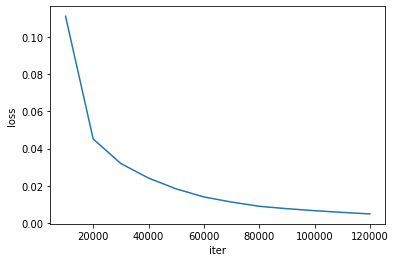

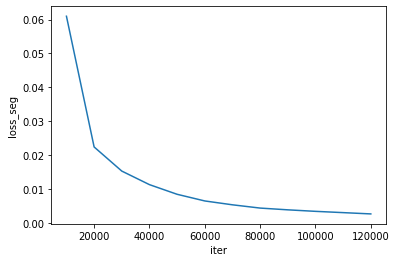

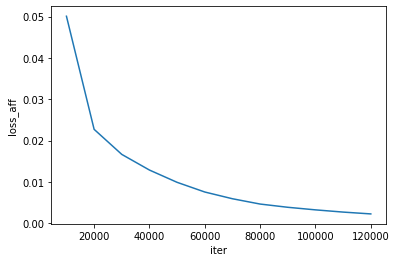

iter:120010, loss:0.0027, loss_seg:0.0017, loss_aff:0.0010
iter:120020, loss:0.0041, loss_seg:0.0018, loss_aff:0.0023
iter:120030, loss:0.0028, loss_seg:0.0016, loss_aff:0.0012
iter:120040, loss:0.0042, loss_seg:0.0025, loss_aff:0.0016
iter:120050, loss:0.0041, loss_seg:0.0019, loss_aff:0.0022
iter:120060, loss:0.0047, loss_seg:0.0020, loss_aff:0.0027
iter:120070, loss:0.0030, loss_seg:0.0019, loss_aff:0.0011
iter:120080, loss:0.0031, loss_seg:0.0014, loss_aff:0.0016
iter:120090, loss:0.0053, loss_seg:0.0026, loss_aff:0.0026
iter:120100, loss:0.0068, loss_seg:0.0039, loss_aff:0.0029
iter:120110, loss:0.0020, loss_seg:0.0011, loss_aff:0.0009
iter:120120, loss:0.0026, loss_seg:0.0017, loss_aff:0.0010
iter:120130, loss:0.0023, loss_seg:0.0013, loss_aff:0.0010
iter:120140, loss:0.0044, loss_seg:0.0025, loss_aff:0.0019
iter:120150, loss:0.0038, loss_seg:0.0026, loss_aff:0.0013
iter:120160, loss:0.0029, loss_seg:0.0021, loss_aff:0.0008
iter:120170, loss:0.0031, loss_seg:0.0018, loss_aff:0.00

iter:121400, loss:0.0087, loss_seg:0.0033, loss_aff:0.0054
iter:121410, loss:0.0037, loss_seg:0.0017, loss_aff:0.0020
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:121420, loss:0.0040, loss_seg:0.0023, loss_aff:0.0016
iter:121430, loss:0.0052, loss_seg:0.0028, loss_aff:0.0025
iter:121440, loss:0.0071, loss_seg:0.0041, loss_aff:0.0031
iter:121450, loss:0.0072, loss_seg:0.0033, loss_aff:0.0039
iter:121460, loss:0.0044, loss_seg:0.0021, loss_aff:0.0024
iter:121470, loss:0.0049, loss_seg:0.0027, loss_aff:0.0021
iter:121480, loss:0.0035, loss_seg:0.0018, loss_aff:0.0017
iter:121490, loss:0.0058, loss_seg:0.0018, loss_aff:0.0040
iter:121500, loss:0.0076, loss_seg:0.0032, loss_aff:0.0044
iter:121510, loss:0.0055, loss_seg:0.0031, loss_aff:0.0023
iter:121520, loss:0.0043, loss_seg:0.0023, loss_aff:0.0020
iter:121530, loss:0.0036, loss_seg:0.0021, loss_aff:0.0015
iter:121540, loss:0.0035, loss_seg:0

iter:122700, loss:0.0041, loss_seg:0.0022, loss_aff:0.0019
iter:122710, loss:0.0042, loss_seg:0.0024, loss_aff:0.0019
iter:122720, loss:0.0022, loss_seg:0.0011, loss_aff:0.0011
iter:122730, loss:0.0029, loss_seg:0.0017, loss_aff:0.0012
iter:122740, loss:0.0042, loss_seg:0.0025, loss_aff:0.0017
iter:122750, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:122760, loss:0.0034, loss_seg:0.0020, loss_aff:0.0014
iter:122770, loss:0.0038, loss_seg:0.0019, loss_aff:0.0019
iter:122780, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:122790, loss:0.0037, loss_seg:0.0020, loss_aff:0.0017
iter:122800, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:122810, loss:0.0031, loss_seg:0.0018, loss_aff:0.0013
iter:122820, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:122830, loss:0.0081, loss_seg:0.0039, loss_aff:0.0042
iter:122840, loss:0.0021, loss_seg:0.0014, loss_aff:0.0007
iter:122850, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:122860, loss:0.0030, loss_seg:0.0018, loss_aff:0.00

iter:124070, loss:0.0062, loss_seg:0.0034, loss_aff:0.0027
iter:124080, loss:0.0038, loss_seg:0.0023, loss_aff:0.0015
iter:124090, loss:0.0034, loss_seg:0.0021, loss_aff:0.0013
iter:124100, loss:0.0022, loss_seg:0.0014, loss_aff:0.0008
iter:124110, loss:0.0033, loss_seg:0.0017, loss_aff:0.0016
iter:124120, loss:0.0033, loss_seg:0.0014, loss_aff:0.0019
iter:124130, loss:0.0021, loss_seg:0.0010, loss_aff:0.0011
iter:124140, loss:0.0047, loss_seg:0.0031, loss_aff:0.0016
iter:124150, loss:0.0063, loss_seg:0.0019, loss_aff:0.0044
iter:124160, loss:0.0037, loss_seg:0.0023, loss_aff:0.0014
iter:124170, loss:0.0043, loss_seg:0.0027, loss_aff:0.0017
iter:124180, loss:0.0068, loss_seg:0.0042, loss_aff:0.0026
iter:124190, loss:0.0029, loss_seg:0.0013, loss_aff:0.0015
iter:124200, loss:0.0030, loss_seg:0.0018, loss_aff:0.0012
iter:124210, loss:0.0038, loss_seg:0.0018, loss_aff:0.0020
iter:124220, loss:0.0048, loss_seg:0.0021, loss_aff:0.0027
iter:124230, loss:0.0026, loss_seg:0.0015, loss_aff:0.00

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:125440, loss:0.0028, loss_seg:0.0017, loss_aff:0.0011
iter:125450, loss:0.0030, loss_seg:0.0017, loss_aff:0.0014
iter:125460, loss:0.0035, loss_seg:0.0021, loss_aff:0.0014
iter:125470, loss:0.0031, loss_seg:0.0013, loss_aff:0.0018
iter:125480, loss:0.0033, loss_seg:0.0016, loss_aff:0.0017
iter:125490, loss:0.0061, loss_seg:0.0021, loss_aff:0.0040
iter:125500, loss:0.0025, loss_seg:0.0013, loss_aff:0.0012
iter:125510, loss:0.0035, loss_seg:0.0020, loss_aff:0.0015
iter:125520, loss:0.0035, loss_seg:0.0021, loss_aff:0.0015
iter:125530, loss:0.0120, loss_seg:0.0022, loss_aff:0.0098
iter:125540, loss:0.0024, loss_seg:0.0015, loss_aff:0.0009
iter:125550, loss:0.0056, loss_seg:0.0035, loss_aff:0.0020
iter:125560, loss:0.0036, loss_seg:0.0021, loss_aff:0.0015
iter:125570, loss:0.0039, loss_seg:0.0020, loss_aff:0.0019
iter:125580, loss:0.0042, loss_seg:0

iter:126810, loss:0.0029, loss_seg:0.0018, loss_aff:0.0011
iter:126820, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:126830, loss:0.0070, loss_seg:0.0032, loss_aff:0.0038
iter:126840, loss:0.0078, loss_seg:0.0043, loss_aff:0.0035
iter:126850, loss:0.0112, loss_seg:0.0057, loss_aff:0.0055
iter:126860, loss:0.0032, loss_seg:0.0016, loss_aff:0.0016
iter:126870, loss:0.0060, loss_seg:0.0034, loss_aff:0.0025
iter:126880, loss:0.0045, loss_seg:0.0026, loss_aff:0.0018
iter:126890, loss:0.0066, loss_seg:0.0038, loss_aff:0.0028
iter:126900, loss:0.0081, loss_seg:0.0045, loss_aff:0.0036
iter:126910, loss:0.0031, loss_seg:0.0017, loss_aff:0.0014
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:126920, loss:0.0062, loss_seg:0.0031, loss_aff:0.0031
iter:126930, loss:0.0020, loss_seg:0.0011, loss_aff:0.0009
iter:126940, loss:0.0038, loss_seg:0.0018, loss_aff:0.0020
iter:126950, loss:0.0058, loss_seg:0.

iter:128180, loss:0.0033, loss_seg:0.0020, loss_aff:0.0014
iter:128190, loss:0.0029, loss_seg:0.0017, loss_aff:0.0012
iter:128200, loss:0.0033, loss_seg:0.0018, loss_aff:0.0015
iter:128210, loss:0.0057, loss_seg:0.0027, loss_aff:0.0030
iter:128220, loss:0.0029, loss_seg:0.0016, loss_aff:0.0013
iter:128230, loss:0.0024, loss_seg:0.0012, loss_aff:0.0012
iter:128240, loss:0.0047, loss_seg:0.0026, loss_aff:0.0021
iter:128250, loss:0.0043, loss_seg:0.0029, loss_aff:0.0014
iter:128260, loss:0.0035, loss_seg:0.0021, loss_aff:0.0014
iter:128270, loss:0.0035, loss_seg:0.0017, loss_aff:0.0018
iter:128280, loss:0.0053, loss_seg:0.0033, loss_aff:0.0021
iter:128290, loss:0.0042, loss_seg:0.0016, loss_aff:0.0026
iter:128300, loss:0.0043, loss_seg:0.0029, loss_aff:0.0015
iter:128310, loss:0.0076, loss_seg:0.0018, loss_aff:0.0059
iter:128320, loss:0.0019, loss_seg:0.0012, loss_aff:0.0007
iter:128330, loss:0.0038, loss_seg:0.0019, loss_aff:0.0019
iter:128340, loss:0.0106, loss_seg:0.0062, loss_aff:0.00

iter:129530, loss:0.0027, loss_seg:0.0014, loss_aff:0.0012
iter:129540, loss:0.0048, loss_seg:0.0033, loss_aff:0.0014
iter:129550, loss:0.0029, loss_seg:0.0015, loss_aff:0.0014
iter:129560, loss:0.0026, loss_seg:0.0018, loss_aff:0.0008
iter:129570, loss:0.0052, loss_seg:0.0036, loss_aff:0.0016
iter:129580, loss:0.0037, loss_seg:0.0020, loss_aff:0.0017
iter:129590, loss:0.0021, loss_seg:0.0014, loss_aff:0.0007
iter:129600, loss:0.0045, loss_seg:0.0028, loss_aff:0.0017
iter:129610, loss:0.0027, loss_seg:0.0020, loss_aff:0.0008
iter:129620, loss:0.0047, loss_seg:0.0033, loss_aff:0.0014
iter:129630, loss:0.0031, loss_seg:0.0019, loss_aff:0.0012
iter:129640, loss:0.0018, loss_seg:0.0011, loss_aff:0.0007
iter:129650, loss:0.0030, loss_seg:0.0021, loss_aff:0.0009
iter:129660, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:129670, loss:0.0041, loss_seg:0.0025, loss_aff:0.0016
iter:129680, loss:0.0026, loss_seg:0.0016, loss_aff:0.0010
iter:129690, loss:0.0033, loss_seg:0.0023, loss_aff:0.00

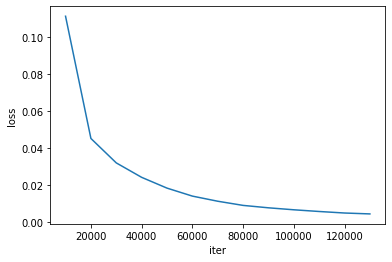

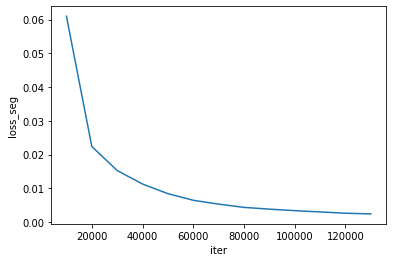

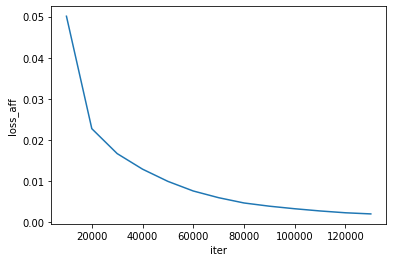

iter:130010, loss:0.0040, loss_seg:0.0015, loss_aff:0.0025
iter:130020, loss:0.0017, loss_seg:0.0011, loss_aff:0.0006
iter:130030, loss:0.0028, loss_seg:0.0016, loss_aff:0.0012
iter:130040, loss:0.0037, loss_seg:0.0024, loss_aff:0.0013
iter:130050, loss:0.0027, loss_seg:0.0018, loss_aff:0.0009
iter:130060, loss:0.0022, loss_seg:0.0014, loss_aff:0.0008
iter:130070, loss:0.0016, loss_seg:0.0011, loss_aff:0.0005
iter:130080, loss:0.0041, loss_seg:0.0027, loss_aff:0.0014
iter:130090, loss:0.0026, loss_seg:0.0016, loss_aff:0.0009
iter:130100, loss:0.0032, loss_seg:0.0017, loss_aff:0.0015
iter:130110, loss:0.0045, loss_seg:0.0029, loss_aff:0.0017
iter:130120, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:130130, loss:0.0039, loss_seg:0.0023, loss_aff:0.0016
iter:130140, loss:0.0031, loss_seg:0.0022, loss_aff:0.0009
iter:130150, loss:0.0040, loss_seg:0.0022, loss_aff:0.0018
iter:130160, loss:0.0015, loss_seg:0.0010, loss_aff:0.0006
iter:130170, loss:0.0035, loss_seg:0.0019, loss_aff:0.00

iter:131360, loss:0.0023, loss_seg:0.0011, loss_aff:0.0012
iter:131370, loss:0.0020, loss_seg:0.0013, loss_aff:0.0007
iter:131380, loss:0.0027, loss_seg:0.0015, loss_aff:0.0012
iter:131390, loss:0.0034, loss_seg:0.0022, loss_aff:0.0012
iter:131400, loss:0.0028, loss_seg:0.0017, loss_aff:0.0011
iter:131410, loss:0.0027, loss_seg:0.0016, loss_aff:0.0011
iter:131420, loss:0.0031, loss_seg:0.0014, loss_aff:0.0016
iter:131430, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:131440, loss:0.0039, loss_seg:0.0023, loss_aff:0.0016
iter:131450, loss:0.0018, loss_seg:0.0012, loss_aff:0.0006
iter:131460, loss:0.0034, loss_seg:0.0022, loss_aff:0.0012
iter:131470, loss:0.0034, loss_seg:0.0017, loss_aff:0.0017
iter:131480, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:131490, loss:0.0050, loss_seg:0.0023, loss_aff:0.0028
iter:131500, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:131510, loss:0.0040, loss_seg:0.0025, loss_aff:0.0015
iter:131520, loss:0.0015, loss_seg:0.0010, loss_aff:0.00

iter:132750, loss:0.0075, loss_seg:0.0039, loss_aff:0.0036
iter:132760, loss:0.0030, loss_seg:0.0017, loss_aff:0.0013
iter:132770, loss:0.0053, loss_seg:0.0031, loss_aff:0.0022
iter:132780, loss:0.0069, loss_seg:0.0031, loss_aff:0.0038
iter:132790, loss:0.0052, loss_seg:0.0030, loss_aff:0.0022
iter:132800, loss:0.0045, loss_seg:0.0023, loss_aff:0.0022
iter:132810, loss:0.0040, loss_seg:0.0026, loss_aff:0.0014
iter:132820, loss:0.0038, loss_seg:0.0020, loss_aff:0.0018
iter:132830, loss:0.0038, loss_seg:0.0022, loss_aff:0.0016
iter:132840, loss:0.0031, loss_seg:0.0020, loss_aff:0.0012
iter:132850, loss:0.0036, loss_seg:0.0014, loss_aff:0.0022
iter:132860, loss:0.0021, loss_seg:0.0012, loss_aff:0.0010
iter:132870, loss:0.0033, loss_seg:0.0017, loss_aff:0.0016
iter:132880, loss:0.0032, loss_seg:0.0018, loss_aff:0.0014
iter:132890, loss:0.0024, loss_seg:0.0013, loss_aff:0.0011
iter:132900, loss:0.0038, loss_seg:0.0019, loss_aff:0.0019
iter:132910, loss:0.0026, loss_seg:0.0013, loss_aff:0.00

iter:134120, loss:0.0037, loss_seg:0.0021, loss_aff:0.0016
iter:134130, loss:0.0035, loss_seg:0.0021, loss_aff:0.0014
iter:134140, loss:0.0020, loss_seg:0.0014, loss_aff:0.0006
iter:134150, loss:0.0030, loss_seg:0.0019, loss_aff:0.0011
iter:134160, loss:0.0026, loss_seg:0.0017, loss_aff:0.0010
iter:134170, loss:0.0027, loss_seg:0.0016, loss_aff:0.0011
iter:134180, loss:0.0025, loss_seg:0.0010, loss_aff:0.0015
iter:134190, loss:0.0026, loss_seg:0.0016, loss_aff:0.0010
iter:134200, loss:0.0033, loss_seg:0.0024, loss_aff:0.0009
iter:134210, loss:0.0037, loss_seg:0.0025, loss_aff:0.0012
iter:134220, loss:0.0024, loss_seg:0.0015, loss_aff:0.0009
iter:134230, loss:0.0025, loss_seg:0.0016, loss_aff:0.0009
iter:134240, loss:0.0027, loss_seg:0.0018, loss_aff:0.0009
iter:134250, loss:0.0026, loss_seg:0.0011, loss_aff:0.0015
iter:134260, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:134270, loss:0.0021, loss_seg:0.0015, loss_aff:0.0007
iter:134280, loss:0.0033, loss_seg:0.0020, loss_aff:0.00

iter:135490, loss:0.0020, loss_seg:0.0012, loss_aff:0.0008
iter:135500, loss:0.0044, loss_seg:0.0026, loss_aff:0.0018
iter:135510, loss:0.0030, loss_seg:0.0013, loss_aff:0.0017
iter:135520, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:135530, loss:0.0026, loss_seg:0.0016, loss_aff:0.0010
iter:135540, loss:0.0027, loss_seg:0.0013, loss_aff:0.0014
iter:135550, loss:0.0020, loss_seg:0.0010, loss_aff:0.0010
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:135560, loss:0.0053, loss_seg:0.0029, loss_aff:0.0024
iter:135570, loss:0.0090, loss_seg:0.0055, loss_aff:0.0035
iter:135580, loss:0.0051, loss_seg:0.0029, loss_aff:0.0022
iter:135590, loss:0.0028, loss_seg:0.0017, loss_aff:0.0010
iter:135600, loss:0.0040, loss_seg:0.0024, loss_aff:0.0016
iter:135610, loss:0.0034, loss_seg:0.0016, loss_aff:0.0018
iter:135620, loss:0.0029, loss_seg:0.0013, loss_aff:0.0016
iter:135630, loss:0.0027, loss_seg:0

iter:136860, loss:0.0049, loss_seg:0.0028, loss_aff:0.0021
iter:136870, loss:0.0049, loss_seg:0.0015, loss_aff:0.0034
iter:136880, loss:0.0021, loss_seg:0.0015, loss_aff:0.0006
iter:136890, loss:0.0046, loss_seg:0.0025, loss_aff:0.0020
iter:136900, loss:0.0050, loss_seg:0.0026, loss_aff:0.0024
iter:136910, loss:0.0071, loss_seg:0.0036, loss_aff:0.0035
iter:136920, loss:0.0076, loss_seg:0.0041, loss_aff:0.0034
iter:136930, loss:0.0049, loss_seg:0.0023, loss_aff:0.0026
iter:136940, loss:0.0036, loss_seg:0.0021, loss_aff:0.0014
iter:136950, loss:0.0088, loss_seg:0.0050, loss_aff:0.0037
iter:136960, loss:0.0061, loss_seg:0.0033, loss_aff:0.0028
iter:136970, loss:0.0106, loss_seg:0.0040, loss_aff:0.0066
iter:136980, loss:0.0062, loss_seg:0.0026, loss_aff:0.0035
iter:136990, loss:0.0112, loss_seg:0.0068, loss_aff:0.0044
iter:137000, loss:0.0029, loss_seg:0.0017, loss_aff:0.0012
iter:137010, loss:0.0042, loss_seg:0.0023, loss_aff:0.0019
iter:137020, loss:0.0054, loss_seg:0.0022, loss_aff:0.00

iter:138210, loss:0.0024, loss_seg:0.0013, loss_aff:0.0010
iter:138220, loss:0.0014, loss_seg:0.0009, loss_aff:0.0005
iter:138230, loss:0.0038, loss_seg:0.0020, loss_aff:0.0018
iter:138240, loss:0.0035, loss_seg:0.0022, loss_aff:0.0013
iter:138250, loss:0.0027, loss_seg:0.0016, loss_aff:0.0012
iter:138260, loss:0.0022, loss_seg:0.0014, loss_aff:0.0009
iter:138270, loss:0.0019, loss_seg:0.0012, loss_aff:0.0007
iter:138280, loss:0.0018, loss_seg:0.0012, loss_aff:0.0006
iter:138290, loss:0.0036, loss_seg:0.0024, loss_aff:0.0012
iter:138300, loss:0.0029, loss_seg:0.0019, loss_aff:0.0010
iter:138310, loss:0.0024, loss_seg:0.0015, loss_aff:0.0009
iter:138320, loss:0.0023, loss_seg:0.0016, loss_aff:0.0007
iter:138330, loss:0.0025, loss_seg:0.0016, loss_aff:0.0009
iter:138340, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:138350, loss:0.0032, loss_seg:0.0016, loss_aff:0.0016
iter:138360, loss:0.0024, loss_seg:0.0016, loss_aff:0.0008
iter:138370, loss:0.0026, loss_seg:0.0014, loss_aff:0.00

iter:139580, loss:0.0036, loss_seg:0.0023, loss_aff:0.0013
iter:139590, loss:0.0017, loss_seg:0.0011, loss_aff:0.0006
iter:139600, loss:0.0017, loss_seg:0.0010, loss_aff:0.0007
iter:139610, loss:0.0023, loss_seg:0.0014, loss_aff:0.0008
iter:139620, loss:0.0022, loss_seg:0.0015, loss_aff:0.0007
iter:139630, loss:0.0030, loss_seg:0.0012, loss_aff:0.0018
iter:139640, loss:0.0014, loss_seg:0.0010, loss_aff:0.0005
iter:139650, loss:0.0030, loss_seg:0.0016, loss_aff:0.0013
iter:139660, loss:0.0037, loss_seg:0.0023, loss_aff:0.0014
iter:139670, loss:0.0033, loss_seg:0.0021, loss_aff:0.0012
iter:139680, loss:0.0021, loss_seg:0.0014, loss_aff:0.0007
iter:139690, loss:0.0023, loss_seg:0.0016, loss_aff:0.0008
iter:139700, loss:0.0030, loss_seg:0.0019, loss_aff:0.0011
iter:139710, loss:0.0024, loss_seg:0.0013, loss_aff:0.0010
iter:139720, loss:0.0032, loss_seg:0.0022, loss_aff:0.0010
iter:139730, loss:0.0023, loss_seg:0.0014, loss_aff:0.0010
iter:139740, loss:0.0017, loss_seg:0.0011, loss_aff:0.00

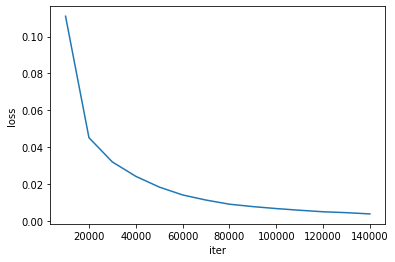

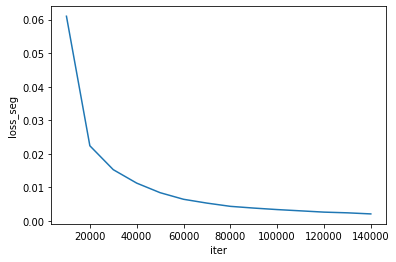

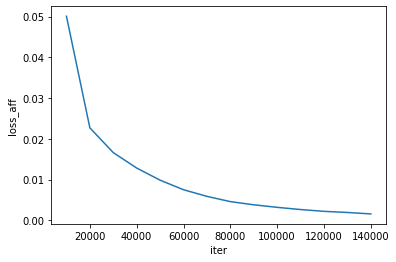

iter:140010, loss:0.0035, loss_seg:0.0023, loss_aff:0.0012
iter:140020, loss:0.0022, loss_seg:0.0013, loss_aff:0.0009
iter:140030, loss:0.0030, loss_seg:0.0015, loss_aff:0.0015
iter:140040, loss:0.0020, loss_seg:0.0011, loss_aff:0.0009
iter:140050, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:140060, loss:0.0026, loss_seg:0.0015, loss_aff:0.0011
iter:140070, loss:0.0060, loss_seg:0.0036, loss_aff:0.0024
iter:140080, loss:0.0023, loss_seg:0.0014, loss_aff:0.0009
iter:140090, loss:0.0026, loss_seg:0.0013, loss_aff:0.0013
iter:140100, loss:0.0020, loss_seg:0.0013, loss_aff:0.0008
iter:140110, loss:0.0040, loss_seg:0.0026, loss_aff:0.0014
iter:140120, loss:0.0033, loss_seg:0.0016, loss_aff:0.0017
iter:140130, loss:0.0021, loss_seg:0.0015, loss_aff:0.0006
iter:140140, loss:0.0031, loss_seg:0.0015, loss_aff:0.0015
iter:140150, loss:0.0036, loss_seg:0.0023, loss_aff:0.0012
iter:140160, loss:0.0039, loss_seg:0.0024, loss_aff:0.0016
iter:140170, loss:0.0023, loss_seg:0.0014, loss_aff:0.00

iter:141380, loss:0.0056, loss_seg:0.0027, loss_aff:0.0029
iter:141390, loss:0.0055, loss_seg:0.0028, loss_aff:0.0027
iter:141400, loss:0.0027, loss_seg:0.0016, loss_aff:0.0011
iter:141410, loss:0.0052, loss_seg:0.0028, loss_aff:0.0025
iter:141420, loss:0.0035, loss_seg:0.0017, loss_aff:0.0018
iter:141430, loss:0.0041, loss_seg:0.0020, loss_aff:0.0021
iter:141440, loss:0.0023, loss_seg:0.0014, loss_aff:0.0009
iter:141450, loss:0.0036, loss_seg:0.0024, loss_aff:0.0012
iter:141460, loss:0.0038, loss_seg:0.0020, loss_aff:0.0018
iter:141470, loss:0.0059, loss_seg:0.0033, loss_aff:0.0025
iter:141480, loss:0.0037, loss_seg:0.0020, loss_aff:0.0017
iter:141490, loss:0.0022, loss_seg:0.0010, loss_aff:0.0012
iter:141500, loss:0.0035, loss_seg:0.0018, loss_aff:0.0016
iter:141510, loss:0.0062, loss_seg:0.0031, loss_aff:0.0031
iter:141520, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:141530, loss:0.0034, loss_seg:0.0023, loss_aff:0.0011
iter:141540, loss:0.0033, loss_seg:0.0019, loss_aff:0.00

iter:142770, loss:0.0027, loss_seg:0.0017, loss_aff:0.0010
iter:142780, loss:0.0034, loss_seg:0.0020, loss_aff:0.0014
iter:142790, loss:0.0030, loss_seg:0.0016, loss_aff:0.0014
iter:142800, loss:0.0058, loss_seg:0.0036, loss_aff:0.0022
iter:142810, loss:0.0032, loss_seg:0.0021, loss_aff:0.0012
iter:142820, loss:0.0056, loss_seg:0.0029, loss_aff:0.0027
iter:142830, loss:0.0036, loss_seg:0.0024, loss_aff:0.0012
iter:142840, loss:0.0025, loss_seg:0.0015, loss_aff:0.0010
iter:142850, loss:0.0080, loss_seg:0.0042, loss_aff:0.0038
iter:142860, loss:0.0024, loss_seg:0.0015, loss_aff:0.0008
iter:142870, loss:0.0036, loss_seg:0.0020, loss_aff:0.0016
iter:142880, loss:0.0058, loss_seg:0.0034, loss_aff:0.0024
iter:142890, loss:0.0024, loss_seg:0.0015, loss_aff:0.0009
iter:142900, loss:0.0026, loss_seg:0.0017, loss_aff:0.0009
iter:142910, loss:0.0038, loss_seg:0.0019, loss_aff:0.0019
iter:142920, loss:0.0022, loss_seg:0.0014, loss_aff:0.0008
iter:142930, loss:0.0025, loss_seg:0.0014, loss_aff:0.00

iter:144120, loss:0.0018, loss_seg:0.0012, loss_aff:0.0006
iter:144130, loss:0.0037, loss_seg:0.0018, loss_aff:0.0019
iter:144140, loss:0.0016, loss_seg:0.0010, loss_aff:0.0005
iter:144150, loss:0.0029, loss_seg:0.0019, loss_aff:0.0010
iter:144160, loss:0.0038, loss_seg:0.0024, loss_aff:0.0014
iter:144170, loss:0.0026, loss_seg:0.0018, loss_aff:0.0009
iter:144180, loss:0.0023, loss_seg:0.0013, loss_aff:0.0010
iter:144190, loss:0.0030, loss_seg:0.0020, loss_aff:0.0010
iter:144200, loss:0.0036, loss_seg:0.0025, loss_aff:0.0011
iter:144210, loss:0.0019, loss_seg:0.0014, loss_aff:0.0006
iter:144220, loss:0.0022, loss_seg:0.0015, loss_aff:0.0006
iter:144230, loss:0.0025, loss_seg:0.0017, loss_aff:0.0008
iter:144240, loss:0.0025, loss_seg:0.0016, loss_aff:0.0009
iter:144250, loss:0.0037, loss_seg:0.0024, loss_aff:0.0013
iter:144260, loss:0.0022, loss_seg:0.0014, loss_aff:0.0007
iter:144270, loss:0.0021, loss_seg:0.0013, loss_aff:0.0008
iter:144280, loss:0.0026, loss_seg:0.0017, loss_aff:0.00

iter:145470, loss:0.0038, loss_seg:0.0024, loss_aff:0.0013
iter:145480, loss:0.0043, loss_seg:0.0026, loss_aff:0.0017
iter:145490, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:145500, loss:0.0022, loss_seg:0.0012, loss_aff:0.0010
iter:145510, loss:0.0060, loss_seg:0.0037, loss_aff:0.0023
iter:145520, loss:0.0051, loss_seg:0.0025, loss_aff:0.0026
iter:145530, loss:0.0033, loss_seg:0.0019, loss_aff:0.0014
iter:145540, loss:0.0042, loss_seg:0.0025, loss_aff:0.0017
iter:145550, loss:0.0039, loss_seg:0.0023, loss_aff:0.0016
iter:145560, loss:0.0026, loss_seg:0.0016, loss_aff:0.0009
iter:145570, loss:0.0023, loss_seg:0.0013, loss_aff:0.0009
iter:145580, loss:0.0051, loss_seg:0.0024, loss_aff:0.0027
iter:145590, loss:0.0031, loss_seg:0.0018, loss_aff:0.0013
iter:145600, loss:0.0045, loss_seg:0.0027, loss_aff:0.0019
iter:145610, loss:0.0028, loss_seg:0.0021, loss_aff:0.0008
iter:145620, loss:0.0022, loss_seg:0.0015, loss_aff:0.0007
iter:145630, loss:0.0028, loss_seg:0.0018, loss_aff:0.00

iter:146860, loss:0.0053, loss_seg:0.0035, loss_aff:0.0018
iter:146870, loss:0.0033, loss_seg:0.0022, loss_aff:0.0011
iter:146880, loss:0.0050, loss_seg:0.0023, loss_aff:0.0026
iter:146890, loss:0.0030, loss_seg:0.0020, loss_aff:0.0009
iter:146900, loss:0.0017, loss_seg:0.0011, loss_aff:0.0005
iter:146910, loss:0.0016, loss_seg:0.0011, loss_aff:0.0005
iter:146920, loss:0.0017, loss_seg:0.0013, loss_aff:0.0005
iter:146930, loss:0.0051, loss_seg:0.0029, loss_aff:0.0022
iter:146940, loss:0.0028, loss_seg:0.0020, loss_aff:0.0008
iter:146950, loss:0.0050, loss_seg:0.0029, loss_aff:0.0021
iter:146960, loss:0.0029, loss_seg:0.0019, loss_aff:0.0010
iter:146970, loss:0.0036, loss_seg:0.0025, loss_aff:0.0011
iter:146980, loss:0.0032, loss_seg:0.0019, loss_aff:0.0012
iter:146990, loss:0.0036, loss_seg:0.0022, loss_aff:0.0014
iter:147000, loss:0.0014, loss_seg:0.0009, loss_aff:0.0005
iter:147010, loss:0.0019, loss_seg:0.0012, loss_aff:0.0007
iter:147020, loss:0.0041, loss_seg:0.0027, loss_aff:0.00

iter:148210, loss:0.0034, loss_seg:0.0015, loss_aff:0.0020
iter:148220, loss:0.0029, loss_seg:0.0018, loss_aff:0.0011
iter:148230, loss:0.0025, loss_seg:0.0015, loss_aff:0.0010
iter:148240, loss:0.0023, loss_seg:0.0014, loss_aff:0.0009
iter:148250, loss:0.0072, loss_seg:0.0022, loss_aff:0.0050
iter:148260, loss:0.0026, loss_seg:0.0015, loss_aff:0.0011
iter:148270, loss:0.0031, loss_seg:0.0021, loss_aff:0.0011
iter:148280, loss:0.0057, loss_seg:0.0038, loss_aff:0.0019
iter:148290, loss:0.0025, loss_seg:0.0012, loss_aff:0.0012
iter:148300, loss:0.0024, loss_seg:0.0015, loss_aff:0.0009
iter:148310, loss:0.0042, loss_seg:0.0023, loss_aff:0.0020
iter:148320, loss:0.0026, loss_seg:0.0017, loss_aff:0.0009
iter:148330, loss:0.0040, loss_seg:0.0023, loss_aff:0.0017
iter:148340, loss:0.0045, loss_seg:0.0025, loss_aff:0.0020
iter:148350, loss:0.0034, loss_seg:0.0021, loss_aff:0.0013
iter:148360, loss:0.0017, loss_seg:0.0011, loss_aff:0.0006
iter:148370, loss:0.0026, loss_seg:0.0016, loss_aff:0.00

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:149580, loss:0.0052, loss_seg:0.0029, loss_aff:0.0023
iter:149590, loss:0.0030, loss_seg:0.0015, loss_aff:0.0014
iter:149600, loss:0.0028, loss_seg:0.0016, loss_aff:0.0012
iter:149610, loss:0.0018, loss_seg:0.0011, loss_aff:0.0007
iter:149620, loss:0.0041, loss_seg:0.0023, loss_aff:0.0019
iter:149630, loss:0.0038, loss_seg:0.0027, loss_aff:0.0011
iter:149640, loss:0.0033, loss_seg:0.0018, loss_aff:0.0015
iter:149650, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:149660, loss:0.0050, loss_seg:0.0028, loss_aff:0.0022
iter:149670, loss:0.0029, loss_seg:0.0017, loss_aff:0.0012
iter:149680, loss:0.0027, loss_seg:0.0017, loss_aff:0.0010
iter:149690, loss:0.0043, loss_seg:0.0023, loss_aff:0.0020
iter:149700, loss:0.0015, loss_seg:0.0009, loss_aff:0.0006
iter:149710, loss:0.0030, loss_seg:0.0015, loss_aff:0.0014
iter:149720, loss:0.0029, loss_seg:0

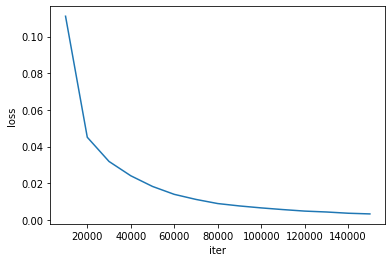

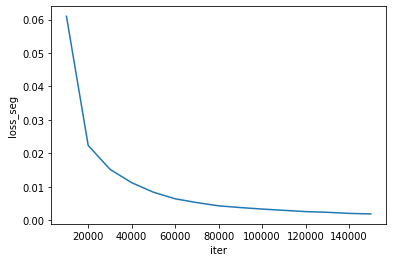

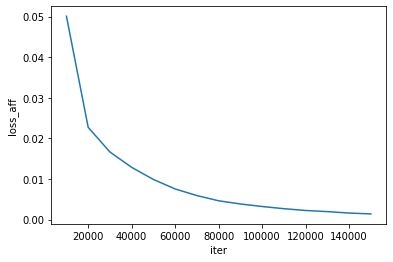

iter:150010, loss:0.0081, loss_seg:0.0039, loss_aff:0.0043
iter:150020, loss:0.0122, loss_seg:0.0059, loss_aff:0.0063
iter:150030, loss:0.0164, loss_seg:0.0097, loss_aff:0.0067
iter:150040, loss:0.0120, loss_seg:0.0069, loss_aff:0.0051
iter:150050, loss:0.0108, loss_seg:0.0053, loss_aff:0.0055
iter:150060, loss:0.0078, loss_seg:0.0029, loss_aff:0.0049
iter:150070, loss:0.0059, loss_seg:0.0030, loss_aff:0.0029
iter:150080, loss:0.0032, loss_seg:0.0019, loss_aff:0.0013
iter:150090, loss:0.0053, loss_seg:0.0028, loss_aff:0.0025
iter:150100, loss:0.0057, loss_seg:0.0038, loss_aff:0.0019
iter:150110, loss:0.0050, loss_seg:0.0023, loss_aff:0.0026
iter:150120, loss:0.0044, loss_seg:0.0024, loss_aff:0.0020
iter:150130, loss:0.0034, loss_seg:0.0018, loss_aff:0.0016
iter:150140, loss:0.0044, loss_seg:0.0020, loss_aff:0.0023
iter:150150, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:150160, loss:0.0047, loss_seg:0.0025, loss_aff:0.0023
iter:150170, loss:0.0064, loss_seg:0.0031, loss_aff:0.00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
single_ex = 3
iter_ = 1
running_loss = 0.0
running_loss_seg = 0.0
running_loss_aff = 0.0
y_loss_axis = []
y_loss_seg_axis = []
y_loss_aff_axis = []
x_axis = []

for epoch in range(EPOCH):  
#     for i in range(1000):
#         data = [x[None] for x in tdw_dataset[single_ex]]
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels, t_aff = data
        inputs = inputs.to(device)
        labels = labels.type(torch.float32)
        labels = labels.to(device)
        t_aff = t_aff.type(torch.float32)
        t_aff = t_aff.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss_seg, loss_aff = calc_loss(outputs, labels, 
                                       t_aff, aff_calc_weight, 
                                       aff_weight, l_aff_weight)
        loss = loss_seg + loss_aff
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_loss_seg += loss_seg.data
        running_loss_aff += loss_aff.data

        iter_ += 1
        
        # logの表示
        if iter_ % LOG_ITER == 0:
            with open(name + "log", mode='a') as f:
                f.write("time:{}, epoch:{}, iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}\n"
                        .format(datetime.datetime.now(), epoch, iter_, 
                                loss.data, loss_seg.data, loss_aff.data))
            print("iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}"
                  .format(iter_, loss.data, loss_seg.data, loss_aff.data))

        if iter_ % SAVE_ITER == 0:
            # lossのグラフ作成
            x_axis.append(iter_)
            y_loss_axis.append(running_loss.item() / SAVE_ITER)
            y_loss_seg_axis.append(running_loss_seg.item() / SAVE_ITER)
            y_loss_aff_axis.append(running_loss_aff.item() / SAVE_ITER)

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss")
            plt.plot(np.array(x_axis),np.array(y_loss_axis))
#             fig.savefig(graph + "loss.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_seg")
            plt.plot(np.array(x_axis),np.array(y_loss_seg_axis))
#             fig.savefig(graph + "loss_seg.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_aff")
            plt.plot(np.array(x_axis),np.array(y_loss_aff_axis))
#             fig.savefig(graph + "loss_aff.png")            

            plt.show()
    
            running_loss = 0.0
            running_loss_seg = 0.0
            running_loss_aff = 0.0

            torch.save(model.state_dict(), trained_model + "model_" + str(iter_) + ".pth")

print('Finished Training')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


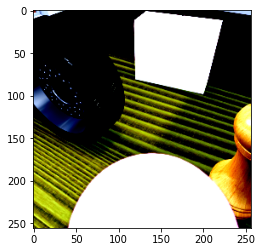

In [22]:
plt.imshow(inputs[0].permute(1,2,0).cpu())
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


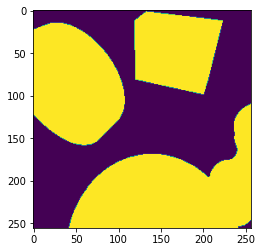

In [23]:
plt.imshow(labels[0].permute(1,2,0).cpu()[:,:,0])
plt.show()

# test on tdw

In [85]:
model.eval()
tdw_val_dataset = datasets.TdwAffinityDataset(training=False, mean=mean, std=std, raft_ckpt=None, 
                                              full_supervision=True)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
ex = single_ex
img, cats, _ = [x[None].cuda() for x in tdw_val_dataset[ex]]
outputs = model(img)
ins, ins_list = make_ins_seg(outputs, st_for=0,
                            en_for=5, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[  0  10  48  68 104 118 173 193 196 252]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


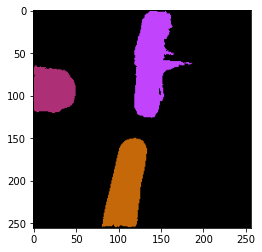

In [87]:
cls_ = 0
print(np.unique(ins[cls_]))
plt.imshow(ins[cls_])
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


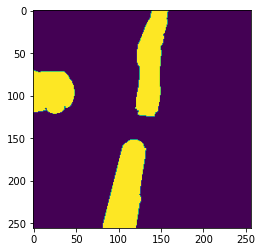

In [88]:
plt.imshow(cats[0].detach().cpu().numpy()[0])

# test

In [19]:
# # 評価するモデルとiterationを指定.
# pre_name = "../exp/exp_1/"
# iter_ = "750000"
# model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
# model = model.to(device)
# model.eval()
# model.load_state_dict(torch.load(pre_name + 'trained_model/model_' + iter_ + '.pth'))

<All keys matched successfully>

In [20]:
model.eval()
print(num_parameters(model))

48401722


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
data_type = "val"
img_path = sorted(glob.glob(DATA_PATH + data_type + "2017/*"))
img_t_path = sorted(glob.glob(DATA_PATH + "semantic_" + data_type + "/*"))
img_ins_t_path = sorted(glob.glob(DATA_PATH + "instance_" + data_type + "/*"))
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# cocoデータセット呼び出し
annFile='../data/annotations/instances_%s2017.json'%(data_type)
coco=COCO(annFile)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [23]:
# クラスとcocoデータセット内でのIndexを渡すと、評価データ内のIndexを返す.
def get_img_ind(cls_ind=0, img_ind=0):
    catIds = coco.getCatIds(catNms=[t_class_name[cls_ind]]);
    imgIds = sorted(coco.getImgIds(catIds=catIds));
    img_name = coco.loadImgs(imgIds[img_ind])[0]['file_name']
    img_name = DATA_PATH + data_type + "2017/" + img_name
    ind_ = img_path.index(img_name)
    print(t_class_name[cls_ind], ind_)
    return ind_

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Semantic Segmentation
def semantic(ind=0, cls_=0):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                     & (img_t[:, :, 1] == t_color[cls_][1])
                     & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))
    output = np.where(output==cls_, 1, 0)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(output)
    plt.show()

    return outputs

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Instance Segmentation
def instance(ind=0, cls_=0, st_for=0, en_for=5, min_size=5):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                      & (img_t[:, :, 1] == t_color[cls_][1])
                      & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))
    
    ins, ins_list = make_ins_seg(outputs, st_for=st_for,
                                 en_for=en_for, min_size=min_size)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(ins[cls_])
    plt.show()

    return outputs, ins

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


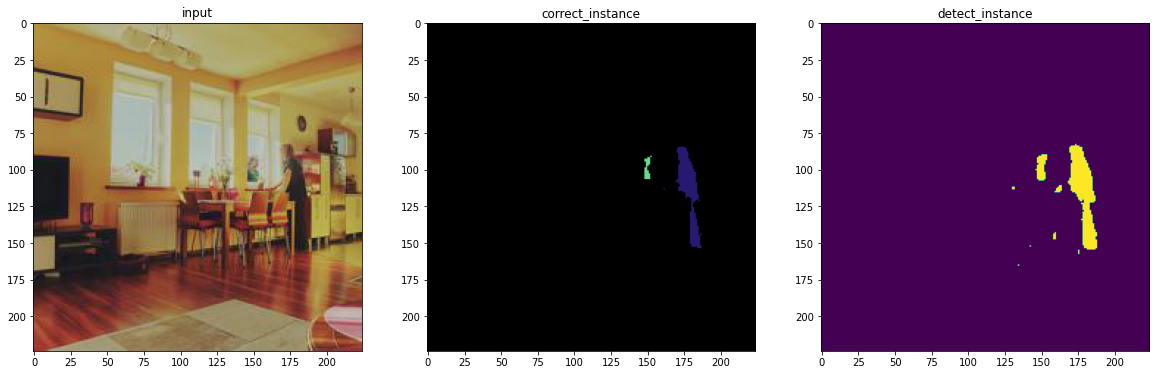

In [26]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = semantic(ind=ind, cls_=cls_ind)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


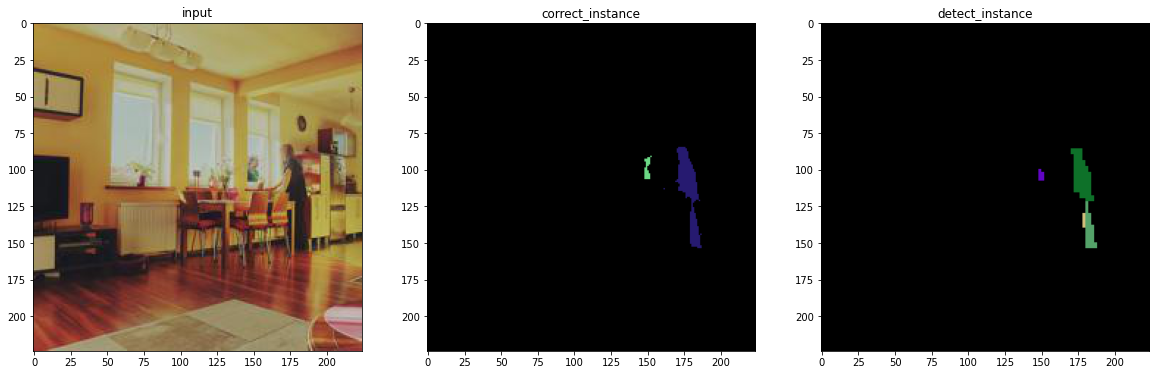

In [33]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 1845
pic_name:../data/resize/val2017/000000212453.jpg


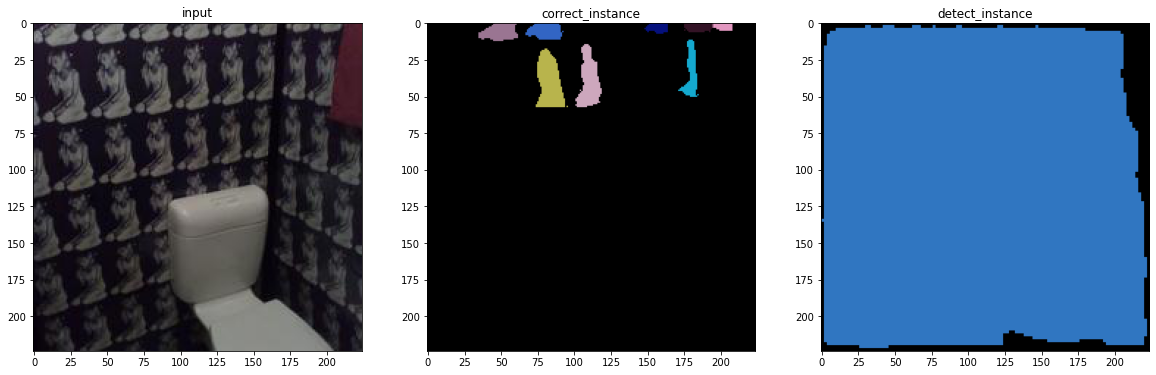

In [26]:
cls_ind = 0
img_ind = 1000
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 191
pic_name:../data/resize/val2017/000000019221.jpg


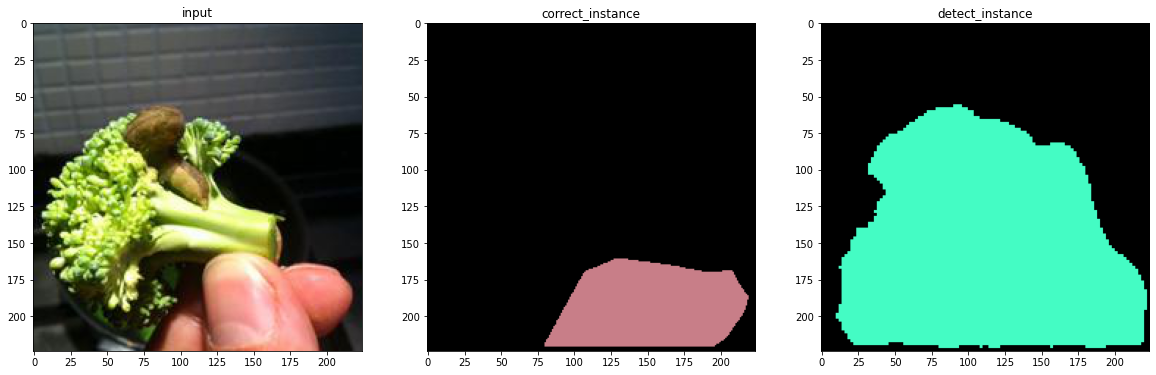

In [27]:
cls_ind = 0
img_ind = 105
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


elephant 710
pic_name:../data/resize/val2017/000000083113.jpg


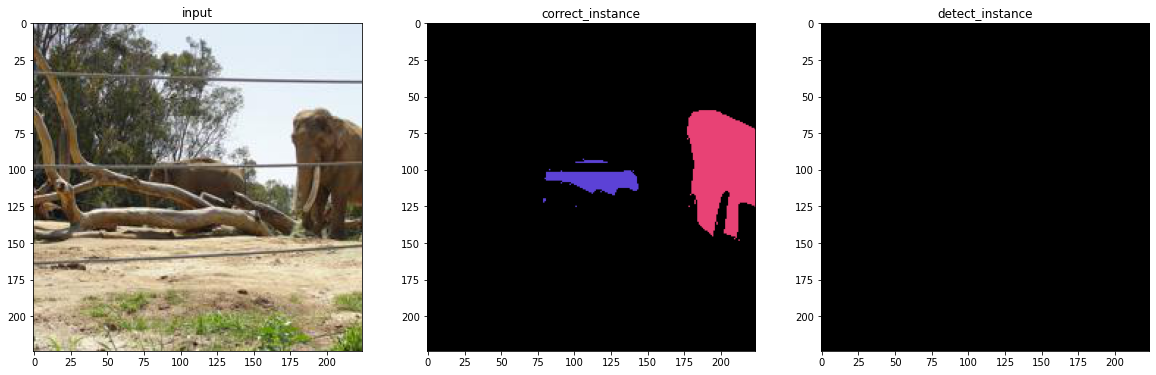

In [29]:
cls_ind = 20
img_ind = 10
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

keyboard 2630
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000036484.jpg


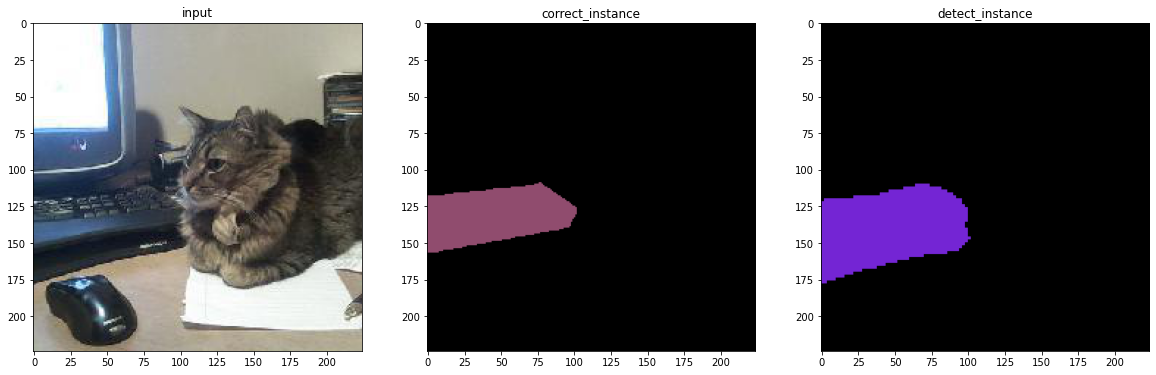

In [21]:
cls_ind = 66
img_ind = 44
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

stop sign 401
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000005635.jpg


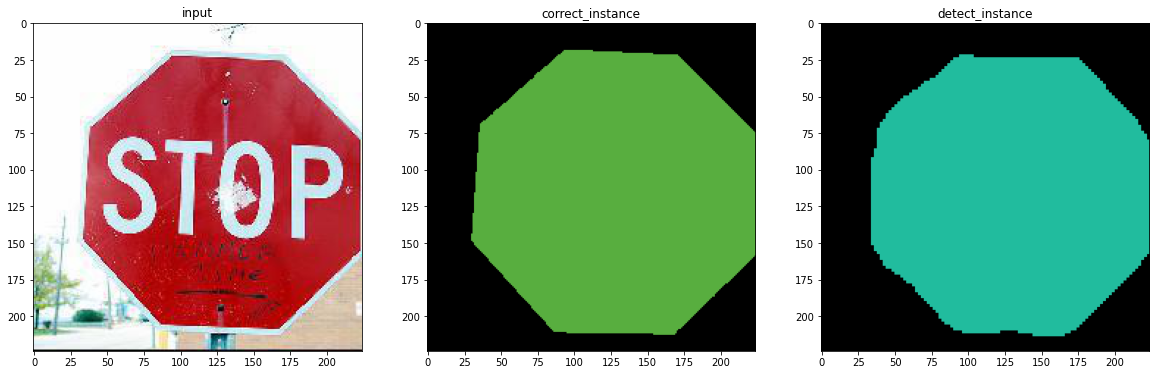

In [42]:
cls_ind = 11
img_ind = 3
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

fork 24806
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000356349.jpg


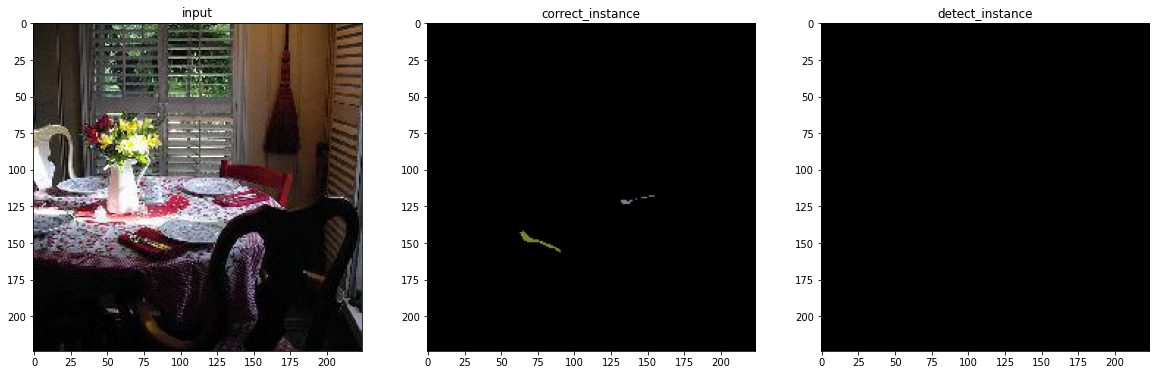

In [63]:
cls_ind = 42
img_ind = 736
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

## Calc metrics

In [21]:
# mIoU
intersection = np.zeros((len(t_color)-1))
union = np.zeros((len(t_color)-1))
iou = np.zeros((len(t_color)-1))
t_area = np.zeros((len(t_color)-1))

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))

    img = preprocess(img)

    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))
    inputs[0] = transform(img)

    with torch.no_grad():
        outputs = model(inputs.to(device))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))

    for cls_ in range(len(t_color)-1):
        output_cls = np.where(output==cls_, 1, 0)
        img_t_cls = np.where((img_t[:, :, 0] == t_color[cls_][0])
                             & (img_t[:, :, 1] == t_color[cls_][1])
                             & (img_t[:, :, 2] == t_color[cls_][2]), 1, 0)
        union[cls_] += np.sum(np.where((output_cls + img_t_cls)>0, 1, 0))
        intersection[cls_] += np.sum(output_cls * img_t_cls)
        t_area[cls_] += np.sum(img_t_cls)

for cls_ in range(len(t_color)-1):
    if union[cls_] == 0:
        iou[cls_] = 0
    else:
        iou[cls_] = intersection[cls_] / union[cls_]

with open(metrics + "metrics_mIoU", mode='w') as f:
    f.write("mIoU:{:.3f}\n"
            .format(np.mean(np.array(iou))))
    for i in range(len(t_color)-1):
        f.write("{}, IoU:{:.3f}, {}, union:{}, t_area:{}, intersection:{}\n"
            .format(i, iou[i], t_class_name[i], union[i],
                    t_area[i], intersection[i]))

np.save(metrics + 'intersection', intersection)
np.save(metrics + 'union', union)
np.save(metrics + 'iou', iou)
np.save(metrics + 't_area', t_area)

100%|██████████| 40504/40504 [53:01<00:00, 12.73it/s]


In [ ]:
# PQ(Panoptic Quality), AP(Average Precision)の計算
TP = np.zeros((len(t_color)-1))
FP = np.zeros((len(t_color)-1))
FN = np.zeros((len(t_color)-1))
IoU_05 = [[] for i in range(len(t_color)-1)]
IoU = np.zeros((len(t_color)-1))
AP = np.zeros((len(t_color)-1))
SQ = np.zeros((len(t_color)-1))
RQ = np.zeros((len(t_color)-1))

st_for=0
en_for=4
min_size=20

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    seg_t = np.asarray(Image.open(img_t_path[ind]))
    ins_t = np.asarray(Image.open(img_ins_t_path[ind]))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
        
    detect, ins_list = make_ins_seg(outputs, st_for=st_for,
                                    en_for=en_for, min_size=min_size)

    for cls_ in range(len(t_color)-1):
        # Falseだと、そのクラスが画像中に存在していないことを示す.
        t_flag = False
        d_flag = False

        # 正解ラベル
        # 該当クラスのinstanceのみ取り出す
        mask = np.where((seg_t[:, :, 0] == t_color[cls_][0])
                        & (seg_t[:, :, 1] == t_color[cls_][1])
                        & (seg_t[:, :, 2] == t_color[cls_][2]),
                        1, 0)[..., None]
        ins_t_cls = ins_t * mask
        if np.max(ins_t_cls)!=0:
            t_flag = True
            # instanceを一つずつ224x224のndarrayに分ける
            ins_colors = ins_t_cls.reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            t_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))

            for i in range(len(ins_colors)):
                t_com[i] = np.where((ins_t_cls[:, :, 0] == ins_colors[i][0])
                                    & (ins_t_cls[:, :, 1] == ins_colors[i][1])
                                    & (ins_t_cls[:, :, 2] == ins_colors[i][2]), 1, 0)

        # 識別結果
        # instanceを一つずつ224x224のndarrayに分ける
        if np.max(detect[cls_])!=0:
            d_flag = True
            ins_colors = detect[cls_].reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            det_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))
            for i in range(len(ins_colors)):
                det_com[i] = np.where((detect[cls_][:, :, 0] == ins_colors[i][0])
                                      & (detect[cls_][:, :, 1] == ins_colors[i][1])
                                      & (detect[cls_][:, :, 2] == ins_colors[i][2]), 1, 0)

        # t_comとdet_comを比較.
        if t_flag == False and d_flag == False:
            continue
        elif t_flag == True and d_flag == False:
            FN[cls_] += len(t_com)
        elif t_flag == False and d_flag == True:
            FP[cls_] += len(det_com)
        else:
            TP_cls = 0
            for i in range(len(det_com)):
                union = np.sum(np.sum(np.clip(t_com + det_com[i], 0, 1), axis=2), axis=1)
                intersection = np.sum(np.sum(t_com * det_com[i], axis=2), axis=1)

                max_IoU = np.max(intersection / union)
                if max_IoU > 0.5:
                    TP_cls += 1
                    IoU[cls_] += max_IoU
                    IoU_05[cls_].append(max_IoU)
            TP[cls_] += TP_cls
            FP[cls_] += len(det_com) - TP_cls
            FN[cls_] += len(t_com) - TP_cls
            
    if ind % 100 == 0:
        with open(metrics + "log", mode='a') as f:
            f.write("index:{}\n".format(ind))

np.save(metrics + 'TP', TP)
np.save(metrics + 'FP', FP)
np.save(metrics + 'FN', FN)
np.save(metrics + 'PQ_IoU', IoU)

for cls_ in range(len(t_color)-1):
    # Segmentation Quality
    if TP[cls_] == 0:
        SQ[cls_] = 0
    else:
        SQ[cls_] = np.array(IoU[cls_]) / np.array(TP[cls_])
    # Recognition Quality
    denominator = TP[cls_] + FP[cls_]/2 + FN[cls_]/2
    if denominator == 0:
        RQ[cls_] = 0
    else:
        RQ[cls_] = TP[cls_] / denominator
    
    # APの計算
    TP_FP = TP[cls_] + FP[cls_]
    if TP_FP == 0:
        AP[cls_] = 0
        continue
    for thresh in range(50, 100, 5):
        th = thresh / 100
        iou_05 = np.asarray(IoU_05[cls_])
        AP[cls_] += np.sum(np.where(iou_05>th, 1, 0)) / TP_FP
AP = AP / 10

# Panoptic Quality
PQ = SQ * RQ

with open(metrics + "metrics_mAP_mPQ", mode='w') as f:
    f.write("mAP{}, mPQ:{}\n"
            .format(np.mean(AP), np.mean(PQ)))
    for i in range(len(t_color)-1):
        f.write("{}, AP:{:.3f}, PQ:{:.3f}, {}\n"
            .format(i, AP[i], PQ[i], t_class_name[i]))

np.save(metrics + 'SQ', SQ)
np.save(metrics + 'RQ', RQ)
np.save(metrics + 'PQ', PQ)
np.save(metrics + 'AP', AP)